In [ ]:
!pip install --upgrade --force-reinstall numpy==1.26.4 pandas==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.

In [ ]:
SUBMISSION = 328

from google.colab import drive
drive.mount('/content/drive')

!pip install catboost -q

# Standard libraries
import os
import glob
import time
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import pickle

# Data handling and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine learning and preprocessing
import sklearn
from sklearn.utils.validation import _check_n_features
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model saving/loading
import joblib

# Get the number of CPU threads available
num_threads = multiprocessing.cpu_count()
print(f"Number of CPU threads available: {num_threads}")

# Filepaths
TRAIN_X = '/content/drive/MyDrive/building_classification/X_train_processed.csv'
TEST_X = '/content/drive/MyDrive/building_classification/X_test_processed.csv'
TRAIN_Y_PATH = '/content/drive/MyDrive/building_classification/Y_train_processed.csv'

SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/sample_submission_v0.1.0.csv.gz'
OUTPUT_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/submission_sub410.csv'

X_test = pd.read_csv(TEST_X)
X_train = pd.read_csv(TRAIN_X)
Y_train = pd.read_csv(TRAIN_Y_PATH)

# Directory to save models
model_save_path = "/content/drive/MyDrive/building_classification/models_sub410/"
# If path exist delete existing folder
if os.path.exists(model_save_path):
    os.system(f"rm -r {model_save_path}")
os.makedirs(model_save_path, exist_ok=True)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 26.1 MB/s eta 0:00:00
Number of CPU threads available: 12


In [ ]:
# display full columns
pd.set_option('display.max_columns', None)
X_train.head()

,ABS_p05_value,ABS_95th_percentile_of_0_1_changes,RATIO_mode_DIV_total_len,RATIO_percentile_95_DIV_percentile_05,RATIO_num_of_unique_DIV_mean,RATIO_unique_DIV_sd,RATIO_sum_reoccur_DIV_unique,RATIO_first_min_to_last_min_DIV_len,RATIO_longest_one_run_ratio,peak_height_min,peak_width_median,peak_width_min,missing_values_ratio,missing_runs_ratio,fraction_of_values_that_are_zero,mean_interval_between_0s,abs_energy_DIV_len,benford_corr,change_quantiles_mean,permutation_entropy_3,seasonal_mean_DIV_seasonal_std,rolling_max_2,rolling_max_144,fft_phase_mean,wavelet_min_haar_1,wavelet_max_haar_2,wavelet_min_haar_2,autocorr_lag_1,autocorr_lag_36,is_Air_Flow_Setpoint,is_Cooling_Supply_Air_Temp_deadband_Setpoint,is_Cooling_Temperature_Setpoint,is_differential_pressure_Setpoint,is_Discharge_Air_Temperature_Setpoint,is_Flow_Setpoint,is_Heating_Demand_Setpoint,is_Heating_Supply_Air_Temperature_Deadband_Setpoint,is_Heating_Temperature_Setpoint,is_Humidity_Setpoint,is_Low_Outside_Air_Temperature_Enable_Setpoint,is_Max_Air_Temperature_Setpoint,is_Min_Air_Temperature_Setpoint,is_Outside_Air_Lockout_Temperature_Setpoint,is_Outside_Air_Temperature_Setpoint,is_Room_Air_Temperature_Setpoint,is_Speed_Setpoint,is_Static_Pressure_Setpoint,is_Temperature_Setpoint,is_Time_Setpoint,is_Water_Temperature_Setpoint,is_Zone_Air_Humidity_Setpoint,RATIO_peak_height_median_DIV_peak_width_median
0,30.00,0.0,0.999750,1.000000,0.066683,4.218478,6.003000e+04,0.000000,0.0,0.00,0.000000,0.000000,0.011991,0.000250,0.000250,0.00000,8.997752e+02,0.062915,0.000000,0.006144,6.122196e-04,30.00,30.00,-1.397833e-17,3.932840e-16,21.213203,6.661338e-16,-0.000250,-0.000252,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0.000000
1,22.50,0.0,0.999875,1.000000,0.088900,7.964365,9.029250e+04,0.000000,0.0,0.00,0.000000,0.000000,0.009717,0.000623,0.000125,0.00000,5.061869e+02,0.295657,0.000000,0.003324,-1.017610e-04,22.50,22.50,2.606887e-16,1.183141e-15,15.909903,4.996004e-16,-0.000125,-0.000125,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.000000
2,1.76,0.0,0.081988,171.781818,18.981519,18.998546,2.120484e+02,0.269565,0.0,100.24,1.529241,0.500536,0.003727,0.001242,0.000000,0.00000,1.747332e+04,0.924611,5.491232,1.682359,6.244451e-18,488.96,488.96,-6.090366e-17,6.567036e-17,258.291965,3.247939e-17,0.970319,0.272470,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116.685368
3,3834.00,0.0,0.999379,1.000000,0.000522,0.020947,1.543568e+07,0.134666,0.0,0.00,0.000000,0.000000,0.002110,0.000869,0.000621,163129.75225,1.469043e+07,0.062915,0.000000,0.009422,2.480123e-18,3834.00,3834.00,2.945529e-16,2.223495e-13,2711.047399,1.081357e-13,-0.000621,-0.000624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
4,234.00,0.0,0.999379,1.000000,0.008552,0.343054,9.412650e+05,0.773665,0.0,0.00,0.000000,0.000000,0.001118,0.000497,0.000621,935935.79025,5.472199e+04,0.295657,0.000000,0.009945,-4.513814e-17,234.00,234.00,3.902600e-04,1.181703e-14,165.462987,0.000000e+00,0.199503,-0.000624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.000000


In [ ]:
# Number of features used
print("Number of features used: " ,len(X_train.columns))

Number of features used:  52


# Training Function

for now only using the best model per label.

In [ ]:
best_model_dict = {
    "Active_Power_Sensor": "cat",
    "Air_Flow_Sensor": "cat",
    "Air_Flow_Setpoint": "cat",
    "Air_Temperature_Sensor": "cat",
    "Air_Temperature_Setpoint": "cat",
    "Alarm": "cat",
    "Angle_Sensor": "cat",
    "Average_Zone_Air_Temperature_Sensor": "cat",
    "Chilled_Water_Differential_Temperature_Sensor": "cat",
    "Chilled_Water_Return_Temperature_Sensor": "cat",
    "Chilled_Water_Supply_Flow_Sensor": "cat",
    "Chilled_Water_Supply_Temperature_Sensor": "cat",
    "Command": "cat",
    'Cooling_Demand_Sensor': "cat",
    "Cooling_Demand_Setpoint": "cat",
    "Cooling_Supply_Air_Temperature_Deadband_Setpoint": "cat",
    "Cooling_Temperature_Setpoint": "cat",
    "Current_Sensor": "cat",
    "Damper_Position_Sensor": "cat",
    "Damper_Position_Setpoint": "cat",
    "Demand_Sensor": "cat",
    "Dew_Point_Setpoint": "cat",
    "Differential_Pressure_Sensor": "cat",
    "Differential_Pressure_Setpoint": "cat",
    "Differential_Supply_Return_Water_Temperature_Sensor": "cat",
    "Discharge_Air_Dewpoint_Sensor": "cat",
    "Discharge_Air_Temperature_Sensor": "cat",
    "Discharge_Air_Temperature_Setpoint": "cat",
    "Discharge_Water_Temperature_Sensor": "cat",
    "Duration_Sensor": "cat",
    "Electrical_Power_Sensor": "cat",
    "Energy_Usage_Sensor": "cat",
    "Filter_Differential_Pressure_Sensor": "cat",
    "Flow_Sensor": "cat",
    "Flow_Setpoint": "cat",
    "Frequency_Sensor": "cat",
    'Heating_Demand_Sensor': "cat",
    "Heating_Demand_Setpoint": "cat",
    "Heating_Supply_Air_Temperature_Deadband_Setpoint": "cat",
    "Heating_Temperature_Setpoint": "cat",
    "Hot_Water_Flow_Sensor": "cat",
    "Hot_Water_Return_Temperature_Sensor": "cat",
    "Hot_Water_Supply_Temperature_Sensor": "cat",
    "Humidity_Setpoint": "cat",
    "Load_Current_Sensor": "cat",
    "Low_Outside_Air_Temperature_Enable_Setpoint": "cat",
    "Max_Air_Temperature_Setpoint": "cat",
    "Min_Air_Temperature_Setpoint": "cat",
    "Outside_Air_CO2_Sensor": "cat",
    "Outside_Air_Enthalpy_Sensor": "cat",
    "Outside_Air_Humidity_Sensor": "cat",
    "Outside_Air_Lockout_Temperature_Setpoint": "cat",
    "Outside_Air_Temperature_Sensor": "cat",
    "Outside_Air_Temperature_Setpoint": "cat",
    "Parameter": "cat",
    "Peak_Power_Demand_Sensor": "cat",
    "Position_Sensor": "cat",
    "Power_Sensor": "cat",
    "Pressure_Sensor": "cat",
    "Rain_Sensor": "cat",
    "Reactive_Power_Sensor": "cat",
    "Reset_Setpoint": "cat",
    "Return_Air_Temperature_Sensor": "cat",
    "Return_Water_Temperature_Sensor": "cat",
    "Room_Air_Temperature_Setpoint": "cat",
    "Sensor": "cat",
    "Setpoint": "cat",
    "Solar_Radiance_Sensor": "cat",
    "Speed_Setpoint": "cat",
    "Static_Pressure_Sensor": "cat",
    "Static_Pressure_Setpoint": "cat",
    "Status": "cat",
    "Supply_Air_Humidity_Sensor": "cat",
    "Supply_Air_Static_Pressure_Sensor": "cat",
    "Supply_Air_Static_Pressure_Setpoint": "cat",
    "Supply_Air_Temperature_Sensor": "cat",
    "Supply_Air_Temperature_Setpoint": "cat",
    "Temperature_Sensor": "cat",
    "Temperature_Setpoint": "cat",
    "Thermal_Power_Sensor": "cat",
    "Time_Setpoint": "cat",
    "Usage_Sensor": "cat",
    "Valve_Position_Sensor": "cat",
    "Voltage_Sensor": "cat",
    "Warmest_Zone_Air_Temperature_Sensor": "cat",
    "Water_Flow_Sensor": "cat",
    "Water_Temperature_Sensor": "cat",
    "Water_Temperature_Setpoint": "cat",
    "Wind_Direction_Sensor": "cat",
    "Wind_Speed_Sensor": "cat",
    "Zone_Air_Dewpoint_Sensor": "cat",
    "Zone_Air_Humidity_Sensor": "cat",
    "Zone_Air_Humidity_Setpoint": "cat",
    "Zone_Air_Temperature_Sensor": "cat",
}

In [ ]:
tuning_params = {{'Air_Flow_Setpoint': {'f1_score': 0.6932,
  'scaling_factor_used': 0.25,
  'n_estimators': 150,
  'learning_rate': 0.2186260768727262,
  'max_depth': 11,
  'l2_leaf_reg': 2.826657138121944},
 'Air_Temperature_Setpoint': {'f1_score': 0.8417,
  'scaling_factor_used': 0.0,
  'n_estimators': 72,
  'learning_rate': 0.05014931708290351,
  'max_depth': 10,
  'l2_leaf_reg': 6.380900719177446},
 'Alarm': {'f1_score': 0.5209,
  'scaling_factor_used': 0.75,
  'n_estimators': 88,
  'learning_rate': 0.19660844397371943,
  'max_depth': 12,
  'l2_leaf_reg': 3.877208168203249},
 'Air_Flow_Sensor': {'f1_score': 0.9049,
  'scaling_factor_used': 0.0,
  'n_estimators': 148,
  'learning_rate': 0.22345783244274064,
  'max_depth': 10,
  'l2_leaf_reg': 7.783518782183759},
 'Angle_Sensor': {'f1_score': 0.8629,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Air_Temperature_Sensor': {'f1_score': 0.9197,
  'scaling_factor_used': 0.0,
  'n_estimators': 121,
  'learning_rate': 0.14351794552127023,
  'max_depth': 9,
  'l2_leaf_reg': 1.40824548106748},
 'Average_Zone_Air_Temperature_Sensor': {'f1_score': 0.8917,
  'scaling_factor_used': 0.0,
  'n_estimators': 84,
  'learning_rate': 0.2919133858604093,
  'max_depth': 6,
  'l2_leaf_reg': 4.165162626431081},
 'Chilled_Water_Differential_Temperature_Sensor': {'f1_score': 0.8549,
  'scaling_factor_used': 0.25,
  'n_estimators': 115,
  'learning_rate': 0.22878851740965106,
  'max_depth': 10,
  'l2_leaf_reg': 1.043617369009712},
 'Cooling_Demand_Sensor': {'f1_score': 0.0,
  'scaling_factor_used': 0.1,
  'n_estimators': 100,
  'learning_rate': 0.1,
  'max_depth': 6,
  'l2_leaf_reg': 3.0},
 'Chilled_Water_Return_Temperature_Sensor': {'f1_score': 0.6019,
  'scaling_factor_used': 0.5,
  'n_estimators': 71,
  'learning_rate': 0.21782615019916574,
  'max_depth': 8,
  'l2_leaf_reg': 1.0579227891677057},
 'Chilled_Water_Supply_Flow_Sensor': {'f1_score': 0.6,
  'scaling_factor_used': 0.1,
  'n_estimators': 111,
  'learning_rate': 0.17848207602116636,
  'max_depth': 12,
  'l2_leaf_reg': 1.0161623484120046},
 'Cooling_Demand_Setpoint': {'f1_score': 0.6895,
  'scaling_factor_used': 0.1,
  'n_estimators': 130,
  'learning_rate': 0.22604550815244473,
  'max_depth': 10,
  'l2_leaf_reg': 1.7334864353908195},
 'Chilled_Water_Supply_Temperature_Sensor': {'f1_score': 0.3411,
  'scaling_factor_used': 0.7,
  'n_estimators': 120,
  'learning_rate': 0.14351794552127023,
  'max_depth': 8,
  'l2_leaf_reg': 2.826657138121944},
 'Cooling_Supply_Air_Temperature_Deadband_Setpoint': {'f1_score': 0.8124,
  'scaling_factor_used': 0.1,
  'n_estimators': 113,
  'learning_rate': 0.18300010385787022,
  'max_depth': 7,
  'l2_leaf_reg': 1.014803004239457},
 'Cooling_Temperature_Setpoint': {'f1_score': 0.5223,
  'scaling_factor_used': 0.3,
  'n_estimators': 56,
  'learning_rate': 0.29093230587203855,
  'max_depth': 6,
  'l2_leaf_reg': 3.899177138837614},
 'Active_Power_Sensor': {'f1_score': 0.9172,
  'scaling_factor_used': 0.0,
  'n_estimators': 110,
  'learning_rate': 0.15182718754092042,
  'max_depth': 11,
  'l2_leaf_reg': 7.23787296967925},
 'Damper_Position_Setpoint': {'f1_score': 0.5114,
  'scaling_factor_used': 0.3,
  'n_estimators': 79,
  'learning_rate': 0.2862705536704927,
  'max_depth': 8,
  'l2_leaf_reg': 2.9692095473784517},
 'Command': {'f1_score': 0.3195,
  'scaling_factor_used': 0.7,
  'n_estimators': 115,
  'learning_rate': 0.10815391184779202,
  'max_depth': 10,
  'l2_leaf_reg': 2.818626475113018},
 'Differential_Pressure_Sensor': {'f1_score': 0.9799,
  'scaling_factor_used': 0.1,
  'n_estimators': 56,
  'learning_rate': 0.29093230587203855,
  'max_depth': 6,
  'l2_leaf_reg': 3.899177138837614},
 'Dew_Point_Setpoint': {'f1_score': 0.7975,
  'scaling_factor_used': 0.1,
  'n_estimators': 140,
  'learning_rate': 0.06414065411349704,
  'max_depth': 11,
  'l2_leaf_reg': 1.3748276975484837},
 'Demand_Sensor': {'f1_score': 0.8166,
  'scaling_factor_used': 0.2,
  'n_estimators': 134,
  'learning_rate': 0.16200463282622227,
  'max_depth': 10,
  'l2_leaf_reg': 1.7422567892630747},
 'Discharge_Air_Dewpoint_Sensor': {'f1_score': 0.5527,
  'scaling_factor_used': 0.2,
  'n_estimators': 84,
  'learning_rate': 0.2919133858604093,
  'max_depth': 6,
  'l2_leaf_reg': 4.165162626431081},
 'Current_Sensor': {'f1_score': 0.9027,
  'scaling_factor_used': 0.1,
  'n_estimators': 118,
  'learning_rate': 0.16691984515872094,
  'max_depth': 10,
  'l2_leaf_reg': 1.103121922527846},
 'Differential_Pressure_Setpoint': {'f1_score': 0.9189,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Discharge_Water_Temperature_Sensor': {'f1_score': 0.7647,
  'scaling_factor_used': 0.1,
  'n_estimators': 110,
  'learning_rate': 0.1728922046391847,
  'max_depth': 7,
  'l2_leaf_reg': 1.389758183134082},
 'Discharge_Air_Temperature_Setpoint': {'f1_score': 0.0,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Discharge_Air_Temperature_Sensor': {'f1_score': 0.9555,
  'scaling_factor_used': 0.1,
  'n_estimators': 144,
  'learning_rate': 0.14845130979162455,
  'max_depth': 10,
  'l2_leaf_reg': 2.531366922554211},
 'Damper_Position_Sensor': {'f1_score': 0.6639,
  'scaling_factor_used': 0.0,
  'n_estimators': 95,
  'learning_rate': 0.061572215368601656,
  'max_depth': 12,
  'l2_leaf_reg': 6.374280109947131},
 'Differential_Supply_Return_Water_Temperature_Sensor': {'f1_score': 0.7187,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Filter_Differential_Pressure_Sensor': {'f1_score': 0.9896,
  'scaling_factor_used': 0.1,
  'n_estimators': 112,
  'learning_rate': 0.13454539261783144,
  'max_depth': 11,
  'l2_leaf_reg': 1.2938926514214482},
 'Duration_Sensor': {'f1_score': 0.9628,
  'scaling_factor_used': 0.0,
  'n_estimators': 126,
  'learning_rate': 0.1791864518517776,
  'max_depth': 10,
  'l2_leaf_reg': 4.83482593428573},
 'Heating_Demand_Sensor': {'f1_score': 0.0,
  'scaling_factor_used': 0.1,
  'n_estimators': 100,
  'learning_rate': 0.1,
  'max_depth': 6,
  'l2_leaf_reg': 3.0},
 'Flow_Setpoint': {'f1_score': 0.724,
  'scaling_factor_used': 0.1,
  'n_estimators': 84,
  'learning_rate': 0.2919133858604093,
  'max_depth': 6,
  'l2_leaf_reg': 4.165162626431081},
 'Heating_Supply_Air_Temperature_Deadband_Setpoint': {'f1_score': 0.7111,
  'scaling_factor_used': 0.0,
  'n_estimators': 55,
  'learning_rate': 0.23529500152393482,
  'max_depth': 6,
  'l2_leaf_reg': 2.2134030151935065},
 'Energy_Usage_Sensor': {'f1_score': 0.8975,
  'scaling_factor_used': 0.0,
  'n_estimators': 150,
  'learning_rate': 0.13961866752232988,
  'max_depth': 11,
  'l2_leaf_reg': 1.3748276975484837},
 'Heating_Demand_Setpoint': {'f1_score': 0.2,
  'scaling_factor_used': 0.0,
  'n_estimators': 135,
  'learning_rate': 0.29356955181134786,
  'max_depth': 11,
  'l2_leaf_reg': 2.7426311238053347},
 'Flow_Sensor': {'f1_score': 0.865,
  'scaling_factor_used': 0.1,
  'n_estimators': 133,
  'learning_rate': 0.1318135491173487,
  'max_depth': 12,
  'l2_leaf_reg': 9.569000494637885},
 'Hot_Water_Supply_Temperature_Sensor': {'f1_score': 0.6234,
  'scaling_factor_used': 0.7,
  'n_estimators': 115,
  'learning_rate': 0.29375160618459645,
  'max_depth': 6,
  'l2_leaf_reg': 1.653954879252293},
 'Hot_Water_Return_Temperature_Sensor': {'f1_score': 0.4768,
  'scaling_factor_used': 0.7,
  'n_estimators': 56,
  'learning_rate': 0.29093230587203855,
  'max_depth': 6,
  'l2_leaf_reg': 3.899177138837614},
 'Heating_Temperature_Setpoint': {'f1_score': 0.3775,
  'scaling_factor_used': 0.7,
  'n_estimators': 69,
  'learning_rate': 0.23122086767848973,
  'max_depth': 12,
  'l2_leaf_reg': 5.333519327541091},
 'Hot_Water_Flow_Sensor': {'f1_score': 0.7814,
  'scaling_factor_used': 0.1,
  'n_estimators': 88,
  'learning_rate': 0.19660844397371943,
  'max_depth': 12,
  'l2_leaf_reg': 3.877208168203249},
 'Frequency_Sensor': {'f1_score': 0.8205,
  'scaling_factor_used': 0.0,
  'n_estimators': 133,
  'learning_rate': 0.1318135491173487,
  'max_depth': 12,
  'l2_leaf_reg': 9.569000494637885},
 'Low_Outside_Air_Temperature_Enable_Setpoint': {'f1_score': 0.9572,
  'scaling_factor_used': 0.0,
  'n_estimators': 72,
  'learning_rate': 0.13065029677437695,
  'max_depth': 8,
  'l2_leaf_reg': 2.701890396465201},
 'Humidity_Setpoint': {'f1_score': 0.0989,
  'scaling_factor_used': 1.1,
  'n_estimators': 78,
  'learning_rate': 0.06837403414957428,
  'max_depth': 8,
  'l2_leaf_reg': 1.043821101172735},
 'Min_Air_Temperature_Setpoint': {'f1_score': 0.6143,
  'scaling_factor_used': 0.2,
  'n_estimators': 150,
  'learning_rate': 0.14801533423036808,
  'max_depth': 10,
  'l2_leaf_reg': 2.0692973116895597},
 'Load_Current_Sensor': {'f1_score': 0.5652,
  'scaling_factor_used': 0.8,
  'n_estimators': 116,
  'learning_rate': 0.21123229543923908,
  'max_depth': 8,
  'l2_leaf_reg': 1.0579227891677057},
 'Outside_Air_Enthalpy_Sensor': {'f1_score': 0.5,
  'scaling_factor_used': 0.1,
  'n_estimators': 126,
  'learning_rate': 0.1791864518517776,
  'max_depth': 10,
  'l2_leaf_reg': 4.83482593428573},
 'Max_Air_Temperature_Setpoint': {'f1_score': 0.6981,
  'scaling_factor_used': 0.0,
  'n_estimators': 66,
  'learning_rate': 0.22355294383806806,
  'max_depth': 11,
  'l2_leaf_reg': 1.1053304585401813},
 'Outside_Air_Humidity_Sensor': {'f1_score': 0.5982,
  'scaling_factor_used': 0.2,
  'n_estimators': 72,
  'learning_rate': 0.1021834657651415,
  'max_depth': 8,
  'l2_leaf_reg': 2.701890396465201},
 'Electrical_Power_Sensor': {'f1_score': 0.9322,
  'scaling_factor_used': 0.2,
  'n_estimators': 150,
  'learning_rate': 0.16691984515872094,
  'max_depth': 11,
  'l2_leaf_reg': 8.46783055093723},
 'Outside_Air_Temperature_Sensor': {'f1_score': 0.9538,
  'scaling_factor_used': 0.1,
  'n_estimators': 50,
  'learning_rate': 0.05692553376216519,
  'max_depth': 11,
  'l2_leaf_reg': 1.0848664588453278},
 'Outside_Air_Temperature_Setpoint': {'f1_score': 0.9039,
  'scaling_factor_used': 0.0,
  'n_estimators': 56,
  'learning_rate': 0.29093230587203855,
  'max_depth': 6,
  'l2_leaf_reg': 3.899177138837614},
 'Outside_Air_CO2_Sensor': {'f1_score': 0.0,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Outside_Air_Lockout_Temperature_Setpoint': {'f1_score': 0.9019,
  'scaling_factor_used': 0.0,
  'n_estimators': 135,
  'learning_rate': 0.18409885263879985,
  'max_depth': 11,
  'l2_leaf_reg': 1.0997790025978418},
 'Parameter': {'f1_score': 0.8089,
  'scaling_factor_used': 0.1,
  'n_estimators': 60,
  'learning_rate': 0.22500773850124814,
  'max_depth': 8,
  'l2_leaf_reg': 1.0848664588453278},
 'Peak_Power_Demand_Sensor': {'f1_score': 0.8774,
  'scaling_factor_used': 0.2,
  'n_estimators': 104,
  'learning_rate': 0.2183534435882614,
  'max_depth': 8,
  'l2_leaf_reg': 8.481144386400995},
 'Rain_Sensor': {'f1_score': 0.2733,
  'scaling_factor_used': 0.3,
  'n_estimators': 56,
  'learning_rate': 0.29093230587203855,
  'max_depth': 6,
  'l2_leaf_reg': 3.899177138837614},
 'Reset_Setpoint': {'f1_score': 0.0307,
  'scaling_factor_used': 0.1,
  'n_estimators': 55,
  'learning_rate': 0.11529369826172367,
  'max_depth': 6,
  'l2_leaf_reg': 1.0520578762545196},
 'Pressure_Sensor': {'f1_score': 0.9693,
  'scaling_factor_used': 0.1,
  'n_estimators': 84,
  'learning_rate': 0.2919133858604093,
  'max_depth': 6,
  'l2_leaf_reg': 4.165162626431081},
 'Return_Air_Temperature_Sensor': {'f1_score': 0.812,
  'scaling_factor_used': 0.1,
  'n_estimators': 113,
  'learning_rate': 0.18300010385787022,
  'max_depth': 7,
  'l2_leaf_reg': 1.014803004239457},
 'Return_Water_Temperature_Sensor': {'f1_score': 0.6115,
  'scaling_factor_used': 0.1,
  'n_estimators': 114,
  'learning_rate': 0.12254783215572378,
  'max_depth': 8,
  'l2_leaf_reg': 8.202952341762849},
 'Room_Air_Temperature_Setpoint': {'f1_score': 0.8217,
  'scaling_factor_used': 0.1,
  'n_estimators': 126,
  'learning_rate': 0.1791864518517776,
  'max_depth': 10,
  'l2_leaf_reg': 4.83482593428573},
 'Position_Sensor': {'f1_score': 0.7577,
  'scaling_factor_used': 0.1,
  'n_estimators': 124,
  'learning_rate': 0.06372385360870177,
  'max_depth': 10,
  'l2_leaf_reg': 6.912378351724951},
 'Solar_Radiance_Sensor': {'f1_score': 0.5333,
  'scaling_factor_used': 0.2,
  'n_estimators': 73,
  'learning_rate': 0.05103169554350906,
  'max_depth': 9,
  'l2_leaf_reg': 4.621162240336283},
 'Reactive_Power_Sensor': {'f1_score': 0.9014,
  'scaling_factor_used': 0.0,
  'n_estimators': 150,
  'learning_rate': 0.2240305069589537,
  'max_depth': 11,
  'l2_leaf_reg': 2.017900491342049},
 'Static_Pressure_Setpoint': {'f1_score': 0.5442,
  'scaling_factor_used': 0.1,
  'n_estimators': 115,
  'learning_rate': 0.208239804554005,
  'max_depth': 11,
  'l2_leaf_reg': 2.648919244271998},
 'Sensor': {'f1_score': 0.9464,
  'scaling_factor_used': 0.0,
  'n_estimators': 123,
  'learning_rate': 0.21123123138185107,
  'max_depth': 8,
  'l2_leaf_reg': 2.531366922554211},
 'Speed_Setpoint': {'f1_score': 0.749,
  'scaling_factor_used': 0.1,
  'n_estimators': 119,
  'learning_rate': 0.2196785223454299,
  'max_depth': 10,
  'l2_leaf_reg': 6.254772591960161},
 'Setpoint': {'f1_score': 0.8424,
  'scaling_factor_used': 0.3,
  'n_estimators': 126,
  'learning_rate': 0.1791864518517776,
  'max_depth': 10,
  'l2_leaf_reg': 4.83482593428573},
 'Supply_Air_Humidity_Sensor': {'f1_score': 0.71,
  'scaling_factor_used': 0.1,
  'n_estimators': 66,
  'learning_rate': 0.08337863379072112,
  'max_depth': 9,
  'l2_leaf_reg': 1.0422807475339235},
 'Static_Pressure_Sensor': {'f1_score': 0.9373,
  'scaling_factor_used': 0.0,
  'n_estimators': 116,
  'learning_rate': 0.1844999913251642,
  'max_depth': 10,
  'l2_leaf_reg': 7.783518782183759},
 'Status': {'f1_score': 0.7116,
  'scaling_factor_used': 0.3,
  'n_estimators': 113,
  'learning_rate': 0.10963442433043577,
  'max_depth': 9,
  'l2_leaf_reg': 1.40824548106748},
 'Supply_Air_Static_Pressure_Setpoint': {'f1_score': 0.3645,
  'scaling_factor_used': 0.1,
  'n_estimators': 67,
  'learning_rate': 0.20979746802674643,
  'max_depth': 8,
  'l2_leaf_reg': 2.6402940585250323},
 'Supply_Air_Static_Pressure_Sensor': {'f1_score': 0.7348,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Supply_Air_Temperature_Setpoint': {'f1_score': 0.9261,
  'scaling_factor_used': 0.1,
  'n_estimators': 126,
  'learning_rate': 0.1791864518517776,
  'max_depth': 10,
  'l2_leaf_reg': 4.83482593428573},
 'Power_Sensor': {'f1_score': 0.9301,
  'scaling_factor_used': 0.2,
  'n_estimators': 150,
  'learning_rate': 0.17315695223503358,
  'max_depth': 12,
  'l2_leaf_reg': 7.904950602385088},
 'Supply_Air_Temperature_Sensor': {'f1_score': 0.9851,
  'scaling_factor_used': 0.1,
  'n_estimators': 67,
  'learning_rate': 0.1653044981243747,
  'max_depth': 8,
  'l2_leaf_reg': 1.601545272454966},
 'Temperature_Setpoint': {'f1_score': 0.8478,
  'scaling_factor_used': 0.3,
  'n_estimators': 84,
  'learning_rate': 0.2919133858604093,
  'max_depth': 6,
  'l2_leaf_reg': 4.165162626431081},
 'Temperature_Sensor': {'f1_score': 0.9094,
  'scaling_factor_used': 0.0,
  'n_estimators': 148,
  'learning_rate': 0.12560932561759436,
  'max_depth': 10,
  'l2_leaf_reg': 7.783518782183759},
 'Thermal_Power_Sensor': {'f1_score': 0.6981,
  'scaling_factor_used': 0.0,
  'n_estimators': 112,
  'learning_rate': 0.1942857722106428,
  'max_depth': 12,
  'l2_leaf_reg': 2.4305661926632895},
 'Time_Setpoint': {'f1_score': 0.5744,
  'scaling_factor_used': 0.0,
  'n_estimators': 106,
  'learning_rate': 0.14520157394114405,
  'max_depth': 11,
  'l2_leaf_reg': 9.234102532585528},
 'Usage_Sensor': {'f1_score': 0.842,
  'scaling_factor_used': 0.1,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Warmest_Zone_Air_Temperature_Sensor': {'f1_score': 0.7993,
  'scaling_factor_used': 0.1,
  'n_estimators': 50,
  'learning_rate': 0.16691984515872094,
  'max_depth': 7,
  'l2_leaf_reg': 1.047038381750601},
 'Wind_Direction_Sensor': {'f1_score': 0.8533,
  'scaling_factor_used': 0.1,
  'n_estimators': 111,
  'learning_rate': 0.13633167302801788,
  'max_depth': 7,
  'l2_leaf_reg': 1.1027275296461485},
 'Water_Temperature_Setpoint': {'f1_score': 0.6811,
  'scaling_factor_used': 0.2,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Valve_Position_Sensor': {'f1_score': 0.69,
  'scaling_factor_used': 0.1,
  'n_estimators': 126,
  'learning_rate': 0.053158710679216625,
  'max_depth': 11,
  'l2_leaf_reg': 7.355339236910073},
 'Voltage_Sensor': {'f1_score': 0.9546,
  'scaling_factor_used': 0.0,
  'n_estimators': 88,
  'learning_rate': 0.19660844397371943,
  'max_depth': 12,
  'l2_leaf_reg': 3.877208168203249},
 'Zone_Air_Dewpoint_Sensor': {'f1_score': 0.9137,
  'scaling_factor_used': 0.0,
  'n_estimators': 107,
  'learning_rate': 0.2186260768727262,
  'max_depth': 7,
  'l2_leaf_reg': 7.696675931915644},
 'Wind_Speed_Sensor': {'f1_score': 0.8767,
  'scaling_factor_used': 0.1,
  'n_estimators': 56,
  'learning_rate': 0.29093230587203855,
  'max_depth': 6,
  'l2_leaf_reg': 3.899177138837614},
 'Zone_Air_Humidity_Setpoint': {'f1_score': 0.1947,
  'scaling_factor_used': 0.3,
  'n_estimators': 113,
  'learning_rate': 0.14836904280762706,
  'max_depth': 11,
  'l2_leaf_reg': 1.0848664588453278},
 'Zone_Air_Humidity_Sensor': {'f1_score': 0.9798,
  'scaling_factor_used': 0.1,
  'n_estimators': 149,
  'learning_rate': 0.1532541508242149,
  'max_depth': 7,
  'l2_leaf_reg': 1.24400183311334},
 'Water_Temperature_Sensor': {'f1_score': 0.802,
  'scaling_factor_used': 0.1,
  'n_estimators': 149,
  'learning_rate': 0.06325772269918001,
  'max_depth': 10,
  'l2_leaf_reg': 8.574135502687414},
 'Water_Flow_Sensor': {'f1_score': 0.4923,
  'scaling_factor_used': 0.0,
  'n_estimators': 131,
  'learning_rate': 0.15011911604355738,
  'max_depth': 11,
  'l2_leaf_reg': 9.240862770451454},
 'Zone_Air_Temperature_Sensor': {'f1_score': 0.9614,
  'scaling_factor_used': 0.0,
  'n_estimators': 138,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391}}}

TypeError: unhashable type: 'dict'

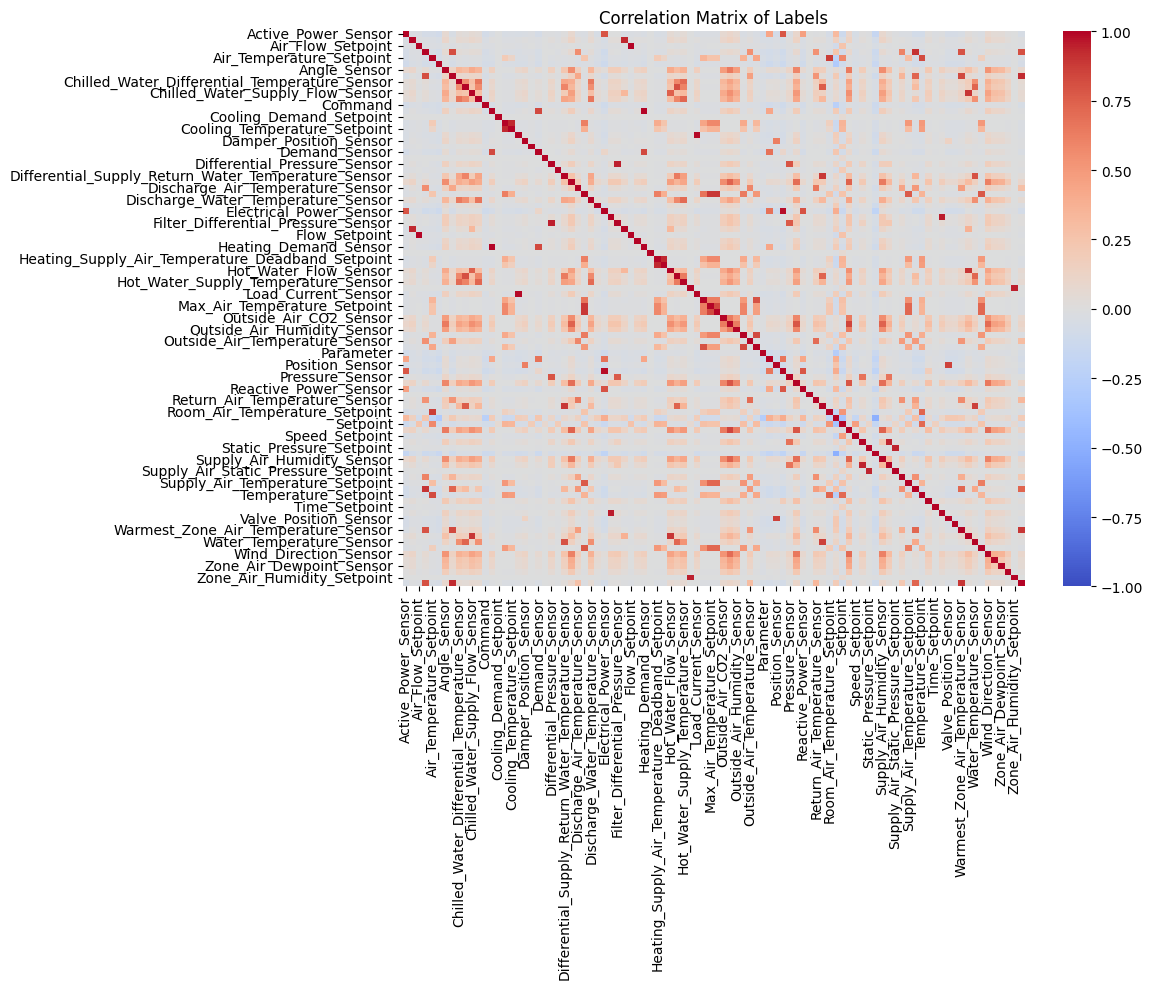

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from collections import defaultdict
import json

# 计算相关矩阵
correlation_matrix = Y_train.corr()

# 可视化相关性矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Labels')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate average absolute correlation (excluding diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Upper triangle mask
tri_corr = correlation_matrix.mask(mask).abs()  # Absolute values only
mean_corr = tri_corr.sum().sum() / tri_corr.count().sum()
print(f"Average absolute correlation between labels: {mean_corr:.4f}")

# Find strongly correlated pairs (|correlation| > threshold)
threshold = 0.8
strong_pairs = []
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > threshold:
            strong_pairs.append((cols[i], cols[j], corr))

# Print strong correlated pairs
print(f"\nStrongly correlated pairs (|correlation| > {threshold}), total: {len(strong_pairs)}")
for label1, label2, corr in strong_pairs:
    print(f"  {label1} - {label2}: {corr:.4f}")

# Get unique labels involved in strong pairs
strong_labels = set()
for l1, l2, _ in strong_pairs:
    strong_labels.add(l1)
    strong_labels.add(l2)
strong_labels = sorted(strong_labels)

# Identify weak labels (not in any strong pair)
weak_labels = sorted([col for col in Y_train.columns if col not in strong_labels])

# Print label counts
print(f"\nNumber of strong labels: {len(strong_labels)}")
print(f"Number of weak labels: {len(weak_labels)}")

# Optionally print weak labels
print("\nWeak labels:")
for label in weak_labels:
    print(f"  {label}")

Average absolute correlation between labels: 0.1009

Strongly correlated pairs (|correlation| > 0.8), total: 36
  Air_Flow_Sensor - Flow_Sensor: 0.9355
  Air_Flow_Setpoint - Flow_Setpoint: 0.9927
  Air_Temperature_Sensor - Average_Zone_Air_Temperature_Sensor: 0.8130
  Air_Temperature_Sensor - Temperature_Sensor: 0.8996
  Air_Temperature_Sensor - Warmest_Zone_Air_Temperature_Sensor: 0.8030
  Air_Temperature_Sensor - Zone_Air_Temperature_Sensor: 0.8116
  Air_Temperature_Setpoint - Room_Air_Temperature_Setpoint: 0.8698
  Air_Temperature_Setpoint - Temperature_Setpoint: 0.8232
  Average_Zone_Air_Temperature_Sensor - Warmest_Zone_Air_Temperature_Sensor: 0.8332
  Average_Zone_Air_Temperature_Sensor - Zone_Air_Temperature_Sensor: 0.9291
  Chilled_Water_Return_Temperature_Sensor - Hot_Water_Return_Temperature_Sensor: 0.8097
  Chilled_Water_Supply_Flow_Sensor - Water_Flow_Sensor: 0.8915
  Cooling_Demand_Sensor - Demand_Sensor: 0.8338
  Cooling_Demand_Sensor - Heating_Demand_Sensor: 1.0000
  Coo

In [ ]:
weak_labels = [
    'Active_Power_Sensor', 'Alarm', 'Angle_Sensor', 'Chilled_Water_Differential_Temperature_Sensor',
    'Chilled_Water_Supply_Temperature_Sensor', 'Command', 'Cooling_Demand_Setpoint',
    'Damper_Position_Sensor', 'Damper_Position_Setpoint', 'Dew_Point_Setpoint',
    'Differential_Pressure_Setpoint', 'Discharge_Air_Dewpoint_Sensor',
    'Discharge_Air_Temperature_Sensor', 'Discharge_Water_Temperature_Sensor', 'Duration_Sensor',
    'Frequency_Sensor', 'Heating_Demand_Setpoint', 'Hot_Water_Supply_Temperature_Sensor',
    'Low_Outside_Air_Temperature_Enable_Setpoint', 'Outside_Air_CO2_Sensor',
    'Outside_Air_Humidity_Sensor', 'Outside_Air_Temperature_Sensor', 'Parameter',
    'Peak_Power_Demand_Sensor', 'Pressure_Sensor', 'Rain_Sensor', 'Reset_Setpoint',
    'Return_Air_Temperature_Sensor', 'Sensor', 'Setpoint', 'Speed_Setpoint', 'Status',
    'Supply_Air_Humidity_Sensor', 'Supply_Air_Temperature_Sensor', 'Supply_Air_Temperature_Setpoint',
    'Thermal_Power_Sensor', 'Time_Setpoint', 'Voltage_Sensor', 'Water_Temperature_Setpoint',
    'Wind_Direction_Sensor', 'Wind_Speed_Sensor', 'Zone_Air_Dewpoint_Sensor',
    'Zone_Air_Humidity_Sensor'
]

strong_labels = [
    'Air_Flow_Sensor', 'Air_Flow_Setpoint', 'Air_Temperature_Sensor', 'Air_Temperature_Setpoint',
    'Average_Zone_Air_Temperature_Sensor', 'Chilled_Water_Return_Temperature_Sensor',
    'Chilled_Water_Supply_Flow_Sensor', 'Cooling_Demand_Sensor',
    'Cooling_Supply_Air_Temperature_Deadband_Setpoint', 'Cooling_Temperature_Setpoint',
    'Current_Sensor', 'Demand_Sensor', 'Differential_Pressure_Sensor',
    'Differential_Supply_Return_Water_Temperature_Sensor', 'Discharge_Air_Temperature_Setpoint',
    'Electrical_Power_Sensor', 'Energy_Usage_Sensor', 'Filter_Differential_Pressure_Sensor',
    'Flow_Sensor', 'Flow_Setpoint', 'Heating_Demand_Sensor',
    'Heating_Supply_Air_Temperature_Deadband_Setpoint', 'Heating_Temperature_Setpoint',
    'Hot_Water_Flow_Sensor', 'Hot_Water_Return_Temperature_Sensor', 'Humidity_Setpoint',
    'Load_Current_Sensor', 'Max_Air_Temperature_Setpoint', 'Min_Air_Temperature_Setpoint',
    'Outside_Air_Enthalpy_Sensor', 'Outside_Air_Lockout_Temperature_Setpoint',
    'Outside_Air_Temperature_Setpoint', 'Position_Sensor', 'Power_Sensor',
    'Reactive_Power_Sensor', 'Return_Water_Temperature_Sensor', 'Room_Air_Temperature_Setpoint',
    'Solar_Radiance_Sensor', 'Static_Pressure_Sensor', 'Static_Pressure_Setpoint',
    'Supply_Air_Static_Pressure_Sensor', 'Supply_Air_Static_Pressure_Setpoint',
    'Temperature_Sensor', 'Temperature_Setpoint', 'Usage_Sensor', 'Valve_Position_Sensor',
    'Warmest_Zone_Air_Temperature_Sensor', 'Water_Flow_Sensor', 'Water_Temperature_Sensor',
    'Zone_Air_Humidity_Setpoint', 'Zone_Air_Temperature_Sensor'
]


In [ ]:
# new
hierarchy = {
    'Sensor': [
        'Angle_Sensor', 'Outside_Air_CO2_Sensor', 'Current_Sensor', 'Demand_Sensor', 'Wind_Direction_Sensor',
        'Zone_Air_Dewpoint_Sensor', 'Discharge_Air_Dewpoint_Sensor', 'Duration_Sensor', 'Outside_Air_Enthalpy_Sensor',
        'Energy_Usage_Sensor', 'Flow_Sensor', 'Frequency_Sensor', 'Outside_Air_Humidity_Sensor', 'Zone_Air_Humidity_Sensor',
        'Supply_Air_Humidity_Sensor', 'Position_Sensor', 'Power_Sensor', 'Pressure_Sensor', 'Rain_Sensor', 'Voltage_Sensor',
        'Solar_Radiance_Sensor', 'Wind_Speed_Sensor', 'Temperature_Sensor', 'Usage_Sensor'
    ],
    'Current_Sensor': ['Load_Current_Sensor'],
    'Demand_Sensor': ['Cooling_Demand_Sensor', 'Heating_Demand_Sensor', 'Peak_Power_Demand_Sensor'],
    'Flow_Sensor': ['Air_Flow_Sensor', 'Water_Flow_Sensor'],
    'Water_Flow_Sensor': ['Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor'],
    'Position_Sensor': ['Damper_Position_Sensor', 'Valve_Position_Sensor'],
    'Power_Sensor': ['Electrical_Power_Sensor', 'Thermal_Power_Sensor'],
    'Electrical_Power_Sensor': ['Active_Power_Sensor', 'Reactive_Power_Sensor'],
    'Pressure_Sensor': ['Static_Pressure_Sensor', 'Differential_Pressure_Sensor'],
    'Static_Pressure_Sensor': ['Supply_Air_Static_Pressure_Sensor'],
    'Differential_Pressure_Sensor': ['Filter_Differential_Pressure_Sensor'],
    'Temperature_Sensor': ['Water_Temperature_Sensor', 'Air_Temperature_Sensor'],
    'Water_Temperature_Sensor': [
        'Hot_Water_Supply_Temperature_Sensor', 'Chilled_Water_Differential_Temperature_Sensor',
        'Return_Water_Temperature_Sensor'
    ],
    'Return_Water_Temperature_Sensor': [
        'Hot_Water_Return_Temperature_Sensor', 'Chilled_Water_Return_Temperature_Sensor',
        'Differential_Supply_Return_Water_Temperature_Sensor'
    ],
    'Air_Temperature_Sensor': [
        'Return_Air_Temperature_Sensor', 'Discharge_Air_Temperature_Sensor', 'Supply_Air_Temperature_Sensor',
        'Outside_Air_Temperature_Sensor'
    ],
    'Outside_Air_Temperature_Sensor': ['Zone_Air_Temperature_Sensor'],
    'Zone_Air_Temperature_Sensor': ['Average_Zone_Air_Temperature_Sensor', 'Warmest_Zone_Air_Temperature_Sensor'],
    'Setpoint': [
        'Damper_Position_Setpoint', 'Cooling_Demand_Setpoint', 'Heating_Demand_Setpoint', 'Dew_Point_Setpoint',
        'Flow_Setpoint', 'Humidity_Setpoint', 'Reset_Setpoint', 'Differential_Pressure_Setpoint',
        'Static_Pressure_Setpoint', 'Speed_Setpoint', 'Temperature_Setpoint', 'Time_Setpoint'
    ],
    'Flow_Setpoint': ['Air_Flow_Setpoint'],
    'Humidity_Setpoint': ['Zone_Air_Humidity_Setpoint'],
    'Static_Pressure_Setpoint': ['Supply_Air_Static_Pressure_Setpoint'],
    'Temperature_Setpoint': [
        'Air_Temperature_Setpoint', 'Cooling_Temperature_Setpoint', 'Heating_Temperature_Setpoint',
        'Water_Temperature_Setpoint', 'Room_Air_Temperature_Setpoint', 'Supply_Air_Temperature_Setpoint'
    ],
    'Air_Temperature_Setpoint': [
        'Discharge_Air_Temperature_Setpoint', 'Max_Air_Temperature_Setpoint', 'Min_Air_Temperature_Setpoint',
        'Outside_Air_Temperature_Setpoint'
    ],
    'Outside_Air_Temperature_Setpoint': ['Outside_Air_Lockout_Temperature_Setpoint', 'Low_Outside_Air_Temperature_Enable_Setpoint'],
    'Cooling_Temperature_Setpoint': ['Cooling_Supply_Air_Temperature_Deadband_Setpoint'],
    'Heating_Temperature_Setpoint': ['Heating_Supply_Air_Temperature_Deadband_Setpoint'],
    'Status': [],
    'Command': [],
    'Parameter': [],
    'Alarm': []
}

In [ ]:
def filter_hierarchy_by_labels(hierarchy, allowed_labels):
    filtered_hierarchy = {}
    for parent, children in hierarchy.items():
        # 判断 parent 或子标签是否在 strong_labels 中
        filtered_children = [child for child in children if child in allowed_labels]
        if parent in allowed_labels or filtered_children:
            filtered_hierarchy[parent] = filtered_children
    return filtered_hierarchy
strong_hierarchy = filter_hierarchy_by_labels(hierarchy, set(strong_labels))
print(strong_hierarchy)

{'Sensor': ['Current_Sensor', 'Demand_Sensor', 'Outside_Air_Enthalpy_Sensor', 'Energy_Usage_Sensor', 'Flow_Sensor', 'Position_Sensor', 'Power_Sensor', 'Solar_Radiance_Sensor', 'Temperature_Sensor', 'Usage_Sensor'], 'Current_Sensor': ['Load_Current_Sensor'], 'Demand_Sensor': ['Cooling_Demand_Sensor', 'Heating_Demand_Sensor'], 'Flow_Sensor': ['Air_Flow_Sensor', 'Water_Flow_Sensor'], 'Water_Flow_Sensor': ['Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor'], 'Position_Sensor': ['Valve_Position_Sensor'], 'Power_Sensor': ['Electrical_Power_Sensor'], 'Electrical_Power_Sensor': ['Reactive_Power_Sensor'], 'Pressure_Sensor': ['Static_Pressure_Sensor', 'Differential_Pressure_Sensor'], 'Static_Pressure_Sensor': ['Supply_Air_Static_Pressure_Sensor'], 'Differential_Pressure_Sensor': ['Filter_Differential_Pressure_Sensor'], 'Temperature_Sensor': ['Water_Temperature_Sensor', 'Air_Temperature_Sensor'], 'Water_Temperature_Sensor': ['Return_Water_Temperature_Sensor'], 'Return_Water_Temperature_S

In [ ]:
all_hierarchy_labels = set()
for parent, children in hierarchy.items():
    all_hierarchy_labels.add(parent)
    all_hierarchy_labels.update(children)

# Weak labels = 总 label - strong_hierarchy 所有 label
used_strong_labels = set()
for group, labels in strong_hierarchy.items():
    used_strong_labels.add(group)
    used_strong_labels.update(labels)

new_weak_labels = set(weak_labels) - used_strong_labels
print(new_weak_labels)


{'Angle_Sensor', 'Hot_Water_Supply_Temperature_Sensor', 'Reset_Setpoint', 'Voltage_Sensor', 'Chilled_Water_Supply_Temperature_Sensor', 'Zone_Air_Dewpoint_Sensor', 'Chilled_Water_Differential_Temperature_Sensor', 'Wind_Speed_Sensor', 'Outside_Air_CO2_Sensor', 'Alarm', 'Thermal_Power_Sensor', 'Damper_Position_Sensor', 'Discharge_Air_Temperature_Sensor', 'Rain_Sensor', 'Outside_Air_Humidity_Sensor', 'Time_Setpoint', 'Zone_Air_Humidity_Sensor', 'Heating_Demand_Setpoint', 'Command', 'Speed_Setpoint', 'Active_Power_Sensor', 'Cooling_Demand_Setpoint', 'Discharge_Air_Dewpoint_Sensor', 'Discharge_Water_Temperature_Sensor', 'Return_Air_Temperature_Sensor', 'Differential_Pressure_Setpoint', 'Status', 'Supply_Air_Temperature_Setpoint', 'Low_Outside_Air_Temperature_Enable_Setpoint', 'Damper_Position_Setpoint', 'Supply_Air_Humidity_Sensor', 'Supply_Air_Temperature_Sensor', 'Parameter', 'Water_Temperature_Setpoint', 'Dew_Point_Setpoint', 'Duration_Sensor', 'Frequency_Sensor', 'Peak_Power_Demand_Senso

In [ ]:
# 1. strong_hierarchy_dict（直接来自你上面输出的 strong_hierarchy）
strong_hierarchy_dict = {
    'Sensor': ['Current_Sensor', 'Demand_Sensor', 'Outside_Air_Enthalpy_Sensor', 'Energy_Usage_Sensor', 'Flow_Sensor', 'Position_Sensor', 'Power_Sensor', 'Solar_Radiance_Sensor', 'Temperature_Sensor', 'Usage_Sensor'],
    'Current_Sensor': ['Load_Current_Sensor'],
    'Demand_Sensor': ['Cooling_Demand_Sensor', 'Heating_Demand_Sensor'],
    'Flow_Sensor': ['Air_Flow_Sensor', 'Water_Flow_Sensor'],
    'Water_Flow_Sensor': ['Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor'],
    'Position_Sensor': ['Valve_Position_Sensor'],
    'Power_Sensor': ['Electrical_Power_Sensor'],
    'Electrical_Power_Sensor': ['Reactive_Power_Sensor'],
    'Pressure_Sensor': ['Static_Pressure_Sensor', 'Differential_Pressure_Sensor'],
    'Static_Pressure_Sensor': ['Supply_Air_Static_Pressure_Sensor'],
    'Differential_Pressure_Sensor': ['Filter_Differential_Pressure_Sensor'],
    'Temperature_Sensor': ['Water_Temperature_Sensor', 'Air_Temperature_Sensor'],
    'Water_Temperature_Sensor': ['Return_Water_Temperature_Sensor'],
    'Return_Water_Temperature_Sensor': ['Hot_Water_Return_Temperature_Sensor', 'Chilled_Water_Return_Temperature_Sensor', 'Differential_Supply_Return_Water_Temperature_Sensor'],
    'Air_Temperature_Sensor': [],
    'Outside_Air_Temperature_Sensor': ['Zone_Air_Temperature_Sensor'],
    'Zone_Air_Temperature_Sensor': ['Average_Zone_Air_Temperature_Sensor', 'Warmest_Zone_Air_Temperature_Sensor'],
    'Setpoint': ['Flow_Setpoint', 'Humidity_Setpoint', 'Static_Pressure_Setpoint', 'Temperature_Setpoint'],
    'Flow_Setpoint': ['Air_Flow_Setpoint'],
    'Humidity_Setpoint': ['Zone_Air_Humidity_Setpoint'],
    'Static_Pressure_Setpoint': ['Supply_Air_Static_Pressure_Setpoint'],
    'Temperature_Setpoint': ['Air_Temperature_Setpoint', 'Cooling_Temperature_Setpoint', 'Heating_Temperature_Setpoint', 'Room_Air_Temperature_Setpoint'],
    'Air_Temperature_Setpoint': ['Discharge_Air_Temperature_Setpoint', 'Max_Air_Temperature_Setpoint', 'Min_Air_Temperature_Setpoint', 'Outside_Air_Temperature_Setpoint'],
    'Outside_Air_Temperature_Setpoint': ['Outside_Air_Lockout_Temperature_Setpoint'],
    'Cooling_Temperature_Setpoint': ['Cooling_Supply_Air_Temperature_Deadband_Setpoint'],
    'Heating_Temperature_Setpoint': ['Heating_Supply_Air_Temperature_Deadband_Setpoint']
}

# 2. weak_label_dict（将 new_weak_labels 统一包装为 group）
new_weak_label_dict = {
    'Weak_Labels': sorted([
        'Zone_Air_Humidity_Sensor', 'Outside_Air_Humidity_Sensor', 'Angle_Sensor', 'Wind_Speed_Sensor',
        'Discharge_Air_Temperature_Sensor', 'Return_Air_Temperature_Sensor', 'Voltage_Sensor', 'Speed_Setpoint',
        'Hot_Water_Supply_Temperature_Sensor', 'Rain_Sensor', 'Low_Outside_Air_Temperature_Enable_Setpoint',
        'Discharge_Air_Dewpoint_Sensor', 'Supply_Air_Temperature_Setpoint', 'Wind_Direction_Sensor',
        'Zone_Air_Dewpoint_Sensor', 'Heating_Demand_Setpoint', 'Active_Power_Sensor',
        'Differential_Pressure_Setpoint', 'Supply_Air_Humidity_Sensor', 'Frequency_Sensor',
        'Damper_Position_Sensor', 'Discharge_Water_Temperature_Sensor',
        'Chilled_Water_Differential_Temperature_Sensor', 'Parameter', 'Status',
        'Supply_Air_Temperature_Sensor', 'Outside_Air_CO2_Sensor', 'Damper_Position_Setpoint',
        'Peak_Power_Demand_Sensor', 'Duration_Sensor', 'Water_Temperature_Setpoint',
        'Reset_Setpoint', 'Dew_Point_Setpoint', 'Chilled_Water_Supply_Temperature_Sensor',
        'Cooling_Demand_Setpoint', 'Command', 'Thermal_Power_Sensor', 'Alarm', 'Time_Setpoint'
    ])
}


In [ ]:
# Strong labels：所有 strong_hierarchy_dict 中的唯一标签
strong_labels_from_hierarchy = set()
for parent, children in strong_hierarchy_dict.items():
    strong_labels_from_hierarchy.add(parent)
    strong_labels_from_hierarchy.update(children)

print("Strong labels (from hierarchy):", len(strong_labels_from_hierarchy))  # → 54

# Weak labels
print("Weak labels:", len(new_weak_label_dict['Weak_Labels']))  # → 44


Strong labels (from hierarchy): 55
Weak labels: 39


#model training & Run Training

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import defaultdict
from tqdm import tqdm
import logging
import json

# Configure logging
logging.basicConfig(filename='training.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define strong_hierarchy_dict
strong_hierarchy_dict = {
    'Sensor': ['Current_Sensor', 'Demand_Sensor', 'Outside_Air_Enthalpy_Sensor', 'Energy_Usage_Sensor', 'Flow_Sensor', 'Position_Sensor', 'Power_Sensor', 'Solar_Radiance_Sensor', 'Temperature_Sensor', 'Usage_Sensor'],
    'Current_Sensor': ['Load_Current_Sensor'],
    'Demand_Sensor': ['Cooling_Demand_Sensor', 'Heating_Demand_Sensor'],
    'Flow_Sensor': ['Air_Flow_Sensor', 'Water_Flow_Sensor'],
    'Water_Flow_Sensor': ['Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor'],
    'Position_Sensor': ['Valve_Position_Sensor'],
    'Power_Sensor': ['Electrical_Power_Sensor'],
    'Electrical_Power_Sensor': ['Reactive_Power_Sensor'],
    'Pressure_Sensor': ['Static_Pressure_Sensor', 'Differential_Pressure_Sensor'],
    'Static_Pressure_Sensor': ['Supply_Air_Static_Pressure_Sensor'],
    'Differential_Pressure_Sensor': ['Filter_Differential_Pressure_Sensor'],
    'Temperature_Sensor': ['Water_Temperature_Sensor', 'Air_Temperature_Sensor'],
    'Water_Temperature_Sensor': ['Return_Water_Temperature_Sensor'],
    'Return_Water_Temperature_Sensor': ['Hot_Water_Return_Temperature_Sensor', 'Chilled_Water_Return_Temperature_Sensor', 'Differential_Supply_Return_Water_Temperature_Sensor'],
    'Air_Temperature_Sensor': [],
    'Outside_Air_Temperature_Sensor': ['Zone_Air_Temperature_Sensor'],
    'Zone_Air_Temperature_Sensor': ['Average_Zone_Air_Temperature_Sensor', 'Warmest_Zone_Air_Temperature_Sensor'],
    'Setpoint': ['Flow_Setpoint', 'Humidity_Setpoint', 'Static_Pressure_Setpoint', 'Temperature_Setpoint'],
    'Flow_Setpoint': ['Air_Flow_Setpoint'],
    'Humidity_Setpoint': ['Zone_Air_Humidity_Setpoint'],
    'Static_Pressure_Setpoint': ['Supply_Air_Static_Pressure_Setpoint'],
    'Temperature_Setpoint': ['Air_Temperature_Setpoint', 'Cooling_Temperature_Setpoint', 'Heating_Temperature_Setpoint', 'Room_Air_Temperature_Setpoint'],
    'Air_Temperature_Setpoint': ['Discharge_Air_Temperature_Setpoint', 'Max_Air_Temperature_Setpoint', 'Min_Air_Temperature_Setpoint', 'Outside_Air_Temperature_Setpoint'],
    'Outside_Air_Temperature_Setpoint': ['Outside_Air_Lockout_Temperature_Setpoint'],
    'Cooling_Temperature_Setpoint': ['Cooling_Supply_Air_Temperature_Deadband_Setpoint'],
    'Heating_Temperature_Setpoint': ['Heating_Supply_Air_Temperature_Deadband_Setpoint']
}

# Define new_weak_label_dict
new_weak_label_dict = {
    'Weak_Labels': sorted([
        'Zone_Air_Humidity_Sensor', 'Outside_Air_Humidity_Sensor', 'Angle_Sensor', 'Wind_Speed_Sensor',
        'Discharge_Air_Temperature_Sensor', 'Return_Air_Temperature_Sensor', 'Voltage_Sensor', 'Speed_Setpoint',
        'Hot_Water_Supply_Temperature_Sensor', 'Rain_Sensor', 'Low_Outside_Air_Temperature_Enable_Setpoint',
        'Discharge_Air_Dewpoint_Sensor', 'Supply_Air_Temperature_Setpoint', 'Wind_Direction_Sensor',
        'Zone_Air_Dewpoint_Sensor', 'Heating_Demand_Setpoint', 'Active_Power_Sensor',
        'Differential_Pressure_Setpoint', 'Supply_Air_Humidity_Sensor', 'Frequency_Sensor',
        'Damper_Position_Sensor', 'Discharge_Water_Temperature_Sensor',
        'Chilled_Water_Differential_Temperature_Sensor', 'Parameter', 'Status',
        'Supply_Air_Temperature_Sensor', 'Outside_Air_CO2_Sensor', 'Damper_Position_Setpoint',
        'Peak_Power_Demand_Sensor', 'Duration_Sensor', 'Water_Temperature_Setpoint',
        'Reset_Setpoint', 'Dew_Point_Setpoint', 'Chilled_Water_Supply_Temperature_Sensor',
        'Cooling_Demand_Setpoint', 'Command', 'Thermal_Power_Sensor', 'Alarm', 'Time_Setpoint'
    ])
}

# Utility Functions
def evaluate_label_performance(y_true, y_pred):
    return {
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0)
    }

def create_catboost_classifier(seed, pos_weight):
    return CatBoostClassifier(
        iterations=100,
        random_seed=seed,
        verbose=False,
        thread_count=1,
        scale_pos_weight=pos_weight,
        eval_metric='AUC'
    )

def clean_numeric_data(X):
    if isinstance(X, pd.DataFrame):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_cleaned = X[numeric_cols]
        if X_cleaned.empty:
            raise ValueError("No numeric columns found in the input data")
        X_cleaned = X_cleaned.fillna(0)
        return X_cleaned
    elif isinstance(X, np.ndarray):
        if not np.issubdtype(X.dtype, np.number):
            raise ValueError("Input array contains non-numeric data")
        return np.nan_to_num(X, 0)
    else:
        raise ValueError("Input must be a pandas DataFrame or numpy array")

# Training Functions
def train_classifier_chain_for_group(group_name, label_list, X_train, Y_train, tuned_params, seed, model_save_dir="models"):
    os.makedirs(model_save_dir, exist_ok=True)
    trained_models = {}
    performance_metrics = {}
    confusion_matrices = {}
    X_chain = X_train.copy(deep=True)

    logging.info(f"Starting ClassifierChain for group: {group_name}, seed: {seed}, labels: {label_list}")
    print(f"Starting ClassifierChain for group: {group_name}, seed: {seed}, labels: {label_list}")

    for label in label_list:
        try:
            logging.info(f"Training label: {label} in group: {group_name} (Seed: {seed})")
            print(f"Training label: {label} in group: {group_name} (Seed: {seed})")
            if label not in Y_train.columns:
                print(f"  Skipping label: {label} — not found in Y_train.")
                logging.warning(f"Skipping label: {label} — not found in Y_train.")
                continue
            y = Y_train[label]
            mask = y != 0
            y_binary = y[mask].replace({-1: 0, 1: 1})
            X_sub = X_chain.loc[mask]

            if y_binary.nunique() <= 1:
                print(f"  Skipping label: {label} — only one class present.")
                logging.warning(f"Skipping label: {label} — only one class present.")
                continue

            params = tuned_params.get(label, {})
            scale = params.get("scaling_factor", 0.1)
            ratio = sum(y_binary == 0) / (sum(y_binary == 1) + 1e-6)
            pos_weight = max(1.0, ratio * scale)

            model = create_catboost_classifier(seed, pos_weight)
            model.fit(X_sub, y_binary)
            trained_models[label] = model

            pred_col = f"{label}_pred"
            X_chain[pred_col] = model.predict(X_chain)

            joblib.dump(model, os.path.join(model_save_dir, f"{group_name}_{label}_seed{seed}.joblib"))

            y_pred = model.predict(X_sub)
            performance_metrics[label] = evaluate_label_performance(y_binary, y_pred)
            confusion_matrices[label] = np.array([
                [sum((y_binary == 0) & (y_pred == 0)), sum((y_binary == 0) & (y_pred == 1))],
                [sum((y_binary == 1) & (y_pred == 0)), sum((y_binary == 1) & (y_pred == 1))]
            ])
        except Exception as exc:
            logging.error(f"Error training label: {label} in group: {group_name}, seed: {seed}: {exc}")
            print(f"Error training label: {label} in group: {group_name}: {exc}")
            continue

    logging.info(f"Completed ClassifierChain for group: {group_name}, seed: {seed}")
    print(f"Completed ClassifierChain for group: {group_name}, seed: {seed}")
    return trained_models, performance_metrics, confusion_matrices, X_chain

def train_independent_weak_labels(label, X_train, Y_train, tuned_params, seed, model_save_dir="models"):
    os.makedirs(model_save_dir, exist_ok=True)
    trained_model = None
    performance_metrics = {}
    confusion_matrix = None

    try:
        logging.info(f"Training weak label: {label}, Seed: {seed}")
        print(f"Training weak label: {label}, Seed: {seed}")
        if label not in Y_train.columns:
            raise KeyError(f"Label {label} not found in Y_train")
        y = Y_train[label]
        mask = y != 0
        y_binary = y[mask].replace({-1: 0, 1: 1})
        X_sub = X_train.loc[mask]

        if y_binary.nunique() <= 1:
            print(f"  Skipping label: {label} — only one class present.")
            logging.warning(f"Skipping label: {label} — only one class present.")
            return None, {}, None

        params = tuned_params.get(label, {})
        scale = params.get("scaling_factor", 0.1)
        ratio = sum(y_binary == 0) / (sum(y_binary == 1) + 1e-6)
        pos_weight = max(1.0, ratio * scale)

        model = create_catboost_classifier(seed, pos_weight)
        model.fit(X_sub, y_binary)
        trained_model = model

        joblib.dump(model, os.path.join(model_save_dir, f"weak_{label}_seed{seed}.joblib"))

        y_pred = model.predict(X_sub)
        performance_metrics = evaluate_label_performance(y_binary, y_pred)
        confusion_matrix = np.array([
            [sum((y_binary == 0) & (y_pred == 0)), sum((y_binary == 0) & (y_pred == 1))],
            [sum((y_binary == 1) & (y_pred == 0)), sum((y_binary == 1) & (y_pred == 1))]
        ])
    except Exception as exc:
        logging.error(f"Error training weak label: {label}, seed: {seed}: {exc}")
        print(f"Error training weak label: {label}: {exc}")

    return trained_model, performance_metrics, confusion_matrix

# Tree Node Class and Path Extraction Functions
class TreeNode:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parent = None

    def add_child(self, child_node):
        self.children.append(child_node)
        child_node.parent = self

def build_tree_from_hierarchy(hierarchy_dict):
    nodes = {key: TreeNode(key) for key in hierarchy_dict.keys()}
    for parent_name, children_names in hierarchy_dict.items():
        parent_node = nodes[parent_name]
        for child_name in children_names:
            if child_name not in nodes:
                nodes[child_name] = TreeNode(child_name)
            parent_node.add_child(nodes[child_name])
    return [node for node in nodes.values() if node.parent is None], nodes

def get_paths_from_root(root):
    paths = []
    def traverse(node, current_path):
        current_path.append(node.name)
        if not node.children:
            paths.append(current_path[:])
        for child in node.children:
            traverse(child, current_path)
        current_path.pop()
    traverse(root, [])
    return paths

# Main Training Logic
seeds_to_use=[8, 88, 888, 1, 175, 907, 354, 917, 182, 695, 744, 665, 981,
              876, 286, 241, 159, 219, 868, 277, 521, 278, 755, 387, 113,
              115, 576]
models_dict = defaultdict(dict)
metrics_dict = defaultdict(dict)
confusion_matrices_dict = defaultdict(lambda: None)

# Build paths for grandparent-grandchild relationships
roots, nodes = build_tree_from_hierarchy(strong_hierarchy_dict)
all_paths = []
for root in roots:
    all_paths.extend(get_paths_from_root(root))

print("\nAll paths from roots to leaves:")
for i, path in enumerate(all_paths):
    print(f"Path {i}: {path}")

print("\n=== Integrated Training: Strong, Paths, and Weak Labels ===")
# X_train_enhanced = clean_numeric_data(X_train).copy()

for seed in seeds_to_use:
    print(f"\nTraining with seed {seed}...")
    X_seed_enhanced = clean_numeric_data(X_train).copy()
    # Step 1: Train strong labels (groups from strong_hierarchy_dict)
    print("Training Strong Labels...")
    for group_name, sub_labels in strong_hierarchy_dict.items():
        label_list = [group_name] + sub_labels
        trained_models, performance_metrics, confusion_matrices, X_chain = train_classifier_chain_for_group(
            group_name=group_name,
            label_list=label_list,
            X_train=X_seed_enhanced,
            Y_train=Y_train,
            tuned_params=tuning_params,
            seed=seed,
            model_save_dir="/content/drive/MyDrive/building_classification/models/"
        )
        models_dict[group_name][seed] = {'models': trained_models}
        metrics_dict[group_name][seed] = performance_metrics
        if confusion_matrices:
            for label, cm in confusion_matrices.items():
                if confusion_matrices_dict[label] is None:
                    confusion_matrices_dict[label] = cm
                else:
                    confusion_matrices_dict[label] += cm
        # Update enhanced features
        for label, model in trained_models.items():
            X_seed_enhanced[f"{label}_pred"] = model.predict(X_seed_enhanced)

    # Step 2: Train grandparent-grandchild relationships (paths)
    print("Training Grandparent-Grandchild Paths...")
    for idx, path in enumerate(all_paths):
        group_name = f"Path_{idx}"
        trained_models, performance_metrics, confusion_matrices, X_chain = train_classifier_chain_for_group(
            group_name=group_name,
            label_list=path,
            X_train=X_seed_enhanced,
            Y_train=Y_train,
            tuned_params=tuning_params,
            seed=seed,
            model_save_dir="/content/drive/MyDrive/building_classification/models/"
        )
        models_dict[group_name][seed] = {'models': trained_models}
        metrics_dict[group_name][seed] = performance_metrics
        if confusion_matrices:
            for label, cm in confusion_matrices.items():
                if confusion_matrices_dict[label] is None:
                    confusion_matrices_dict[label] = cm
                else:
                    confusion_matrices_dict[label] += cm
        # Update enhanced features
        for label, model in trained_models.items():
            X_seed_enhanced[f"{label}_pred"] = model.predict(X_seed_enhanced)

    # Step 3: Train weak labels
    print("Training Weak Labels...")
    for label in new_weak_label_dict['Weak_Labels']:
        trained_model, performance_metrics, confusion_matrix = train_independent_weak_labels(
            label=label,
            X_train=X_seed_enhanced,
            Y_train=Y_train,
            tuned_params=tuning_params,
            seed=seed,
            model_save_dir="/content/drive/MyDrive/building_classification/models/"
        )
        if trained_model:
            models_dict['Weak'][seed] = models_dict['Weak'].get(seed, {'models': {}})
            models_dict['Weak'][seed]['models'][label] = trained_model
            metrics_dict['Weak'][seed] = metrics_dict['Weak'].get(seed, {})
            metrics_dict['Weak'][seed][label] = performance_metrics
            if confusion_matrix is not None:
                if confusion_matrices_dict[label] is None:
                    confusion_matrices_dict[label] = confusion_matrix
                else:
                    confusion_matrices_dict[label] += confusion_matrix
            # Update enhanced features
            X_seed_enhanced[f"{label}_pred"] = trained_model.predict(X_seed_enhanced)

print("\nTraining completed.")

def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    return obj

with open('training_metrics.json', 'w') as f:
    json.dump(convert_to_serializable(dict(metrics_dict)), f)

print("Training metrics saved to 'training_metrics.json'.")


All paths from roots to leaves:
Path 0: ['Sensor', 'Current_Sensor', 'Load_Current_Sensor']
Path 1: ['Sensor', 'Demand_Sensor', 'Cooling_Demand_Sensor']
Path 2: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Path 3: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Path 4: ['Sensor', 'Energy_Usage_Sensor']
Path 5: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Path 6: ['Sensor', 'Flow_Sensor', 'Water_Flow_Sensor', 'Hot_Water_Flow_Sensor']
Path 7: ['Sensor', 'Flow_Sensor', 'Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Path 8: ['Sensor', 'Position_Sensor', 'Valve_Position_Sensor']
Path 9: ['Sensor', 'Power_Sensor', 'Electrical_Power_Sensor', 'Reactive_Power_Sensor']
Path 10: ['Sensor', 'Solar_Radiance_Sensor']
Path 11: ['Sensor', 'Temperature_Sensor', 'Water_Temperature_Sensor', 'Return_Water_Temperature_Sensor', 'Hot_Water_Return_Temperature_Sensor']
Path 12: ['Sensor', 'Temperature_Sensor', 'Water_Temperature_Sensor', 'Return_Water_Temperature_Sensor', 'Chilled_Water_Return_Tem

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 8)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 8)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 8
Starting ClassifierChain for group: Flow_Sensor, seed: 8, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 8)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 8)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 8)
Completed ClassifierChain for group: Flow_Sensor, seed: 8
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 8, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 8)
Training label: Hot_Water_Flow_Sensor in group: Water_Flow_Sensor (

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 8)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 8
Starting ClassifierChain for group: Path_2, seed: 8, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 8)
Training label: Demand_Sensor in group: Path_2 (Seed: 8)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 8)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 8
Starting ClassifierChain for group: Path_3, seed: 8, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 8)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 8)
Completed ClassifierChain for group: Path_3, seed: 8
Starting ClassifierChain for group: Path_4, seed: 8, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 8)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 8)
Completed ClassifierChain for group: Path_4, seed: 8
Starting ClassifierChain for group: Path_5, seed: 8, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 8)
Training label: Flow_Sensor in group: Path_5 (Seed: 8)
Training label: Air_Flow_Sensor in group: Path_5 (Seed: 8)
Complete

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 88)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 88)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 88
Starting ClassifierChain for group: Flow_Sensor, seed: 88, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 88)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 88)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 88)
Completed ClassifierChain for group: Flow_Sensor, seed: 88
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 88, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 88)
Training label: Hot_Water_Flow_Sensor in group: Water_Flo

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 88)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 88
Starting ClassifierChain for group: Path_2, seed: 88, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 88)
Training label: Demand_Sensor in group: Path_2 (Seed: 88)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 88)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 88
Starting ClassifierChain for group: Path_3, seed: 88, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 88)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 88)
Completed ClassifierChain for group: Path_3, seed: 88
Starting ClassifierChain for group: Path_4, seed: 88, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 88)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 88)
Completed ClassifierChain for group: Path_4, seed: 88
Starting ClassifierChain for group: Path_5, seed: 88, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 88)
Training label: Flow_Sensor in group: Path_5 (Seed: 88)
Training label: Air_Flow_Sensor in group: Path_5 (Seed

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 888)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 888)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 888
Starting ClassifierChain for group: Flow_Sensor, seed: 888, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 888)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 888)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 888)
Completed ClassifierChain for group: Flow_Sensor, seed: 888
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 888, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 888)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 888)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 888
Starting ClassifierChain for group: Path_2, seed: 888, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 888)
Training label: Demand_Sensor in group: Path_2 (Seed: 888)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 888)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 888
Starting ClassifierChain for group: Path_3, seed: 888, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 888)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 888)
Completed ClassifierChain for group: Path_3, seed: 888
Starting ClassifierChain for group: Path_4, seed: 888, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 888)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 888)
Completed ClassifierChain for group: Path_4, seed: 888
Starting ClassifierChain for group: Path_5, seed: 888, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 888)
Training label: Flow_Sensor in group: Path_5 (Seed: 888)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 1)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 1)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 1
Starting ClassifierChain for group: Flow_Sensor, seed: 1, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 1)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 1)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 1)
Completed ClassifierChain for group: Flow_Sensor, seed: 1
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 1, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 1)
Training label: Hot_Water_Flow_Sensor in group: Water_Flow_Sensor (

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 1)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 1
Starting ClassifierChain for group: Path_2, seed: 1, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 1)
Training label: Demand_Sensor in group: Path_2 (Seed: 1)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 1)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 1
Starting ClassifierChain for group: Path_3, seed: 1, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 1)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 1)
Completed ClassifierChain for group: Path_3, seed: 1
Starting ClassifierChain for group: Path_4, seed: 1, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 1)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 1)
Completed ClassifierChain for group: Path_4, seed: 1
Starting ClassifierChain for group: Path_5, seed: 1, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 1)
Training label: Flow_Sensor in group: Path_5 (Seed: 1)
Training label: Air_Flow_Sensor in group: Path_5 (Seed: 1)
Complete

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 175)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 175)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 175
Starting ClassifierChain for group: Flow_Sensor, seed: 175, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 175)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 175)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 175)
Completed ClassifierChain for group: Flow_Sensor, seed: 175
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 175, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 175)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 175)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 175
Starting ClassifierChain for group: Path_2, seed: 175, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 175)
Training label: Demand_Sensor in group: Path_2 (Seed: 175)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 175)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 175
Starting ClassifierChain for group: Path_3, seed: 175, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 175)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 175)
Completed ClassifierChain for group: Path_3, seed: 175
Starting ClassifierChain for group: Path_4, seed: 175, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 175)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 175)
Completed ClassifierChain for group: Path_4, seed: 175
Starting ClassifierChain for group: Path_5, seed: 175, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 175)
Training label: Flow_Sensor in group: Path_5 (Seed: 175)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 907)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 907)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 907
Starting ClassifierChain for group: Flow_Sensor, seed: 907, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 907)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 907)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 907)
Completed ClassifierChain for group: Flow_Sensor, seed: 907
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 907, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 907)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 907)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 907
Starting ClassifierChain for group: Path_2, seed: 907, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 907)
Training label: Demand_Sensor in group: Path_2 (Seed: 907)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 907)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 907
Starting ClassifierChain for group: Path_3, seed: 907, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 907)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 907)
Completed ClassifierChain for group: Path_3, seed: 907
Starting ClassifierChain for group: Path_4, seed: 907, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 907)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 907)
Completed ClassifierChain for group: Path_4, seed: 907
Starting ClassifierChain for group: Path_5, seed: 907, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 907)
Training label: Flow_Sensor in group: Path_5 (Seed: 907)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 354)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 354)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 354
Starting ClassifierChain for group: Flow_Sensor, seed: 354, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 354)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 354)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 354)
Completed ClassifierChain for group: Flow_Sensor, seed: 354
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 354, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 354)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 354)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 354
Starting ClassifierChain for group: Path_2, seed: 354, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 354)
Training label: Demand_Sensor in group: Path_2 (Seed: 354)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 354)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 354
Starting ClassifierChain for group: Path_3, seed: 354, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 354)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 354)
Completed ClassifierChain for group: Path_3, seed: 354
Starting ClassifierChain for group: Path_4, seed: 354, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 354)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 354)
Completed ClassifierChain for group: Path_4, seed: 354
Starting ClassifierChain for group: Path_5, seed: 354, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 354)
Training label: Flow_Sensor in group: Path_5 (Seed: 354)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 917)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 917)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 917
Starting ClassifierChain for group: Flow_Sensor, seed: 917, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 917)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 917)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 917)
Completed ClassifierChain for group: Flow_Sensor, seed: 917
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 917, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 917)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 917)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 917
Starting ClassifierChain for group: Path_2, seed: 917, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 917)
Training label: Demand_Sensor in group: Path_2 (Seed: 917)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 917)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 917
Starting ClassifierChain for group: Path_3, seed: 917, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 917)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 917)
Completed ClassifierChain for group: Path_3, seed: 917
Starting ClassifierChain for group: Path_4, seed: 917, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 917)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 917)
Completed ClassifierChain for group: Path_4, seed: 917
Starting ClassifierChain for group: Path_5, seed: 917, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 917)
Training label: Flow_Sensor in group: Path_5 (Seed: 917)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 182)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 182)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 182
Starting ClassifierChain for group: Flow_Sensor, seed: 182, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 182)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 182)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 182)
Completed ClassifierChain for group: Flow_Sensor, seed: 182
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 182, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 182)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 182)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 182
Starting ClassifierChain for group: Path_2, seed: 182, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 182)
Training label: Demand_Sensor in group: Path_2 (Seed: 182)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 182)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 182
Starting ClassifierChain for group: Path_3, seed: 182, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 182)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 182)
Completed ClassifierChain for group: Path_3, seed: 182
Starting ClassifierChain for group: Path_4, seed: 182, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 182)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 182)
Completed ClassifierChain for group: Path_4, seed: 182
Starting ClassifierChain for group: Path_5, seed: 182, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 182)
Training label: Flow_Sensor in group: Path_5 (Seed: 182)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 695)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 695)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 695
Starting ClassifierChain for group: Flow_Sensor, seed: 695, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 695)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 695)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 695)
Completed ClassifierChain for group: Flow_Sensor, seed: 695
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 695, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 695)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 695)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 695
Starting ClassifierChain for group: Path_2, seed: 695, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 695)
Training label: Demand_Sensor in group: Path_2 (Seed: 695)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 695)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 695
Starting ClassifierChain for group: Path_3, seed: 695, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 695)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 695)
Completed ClassifierChain for group: Path_3, seed: 695
Starting ClassifierChain for group: Path_4, seed: 695, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 695)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 695)
Completed ClassifierChain for group: Path_4, seed: 695
Starting ClassifierChain for group: Path_5, seed: 695, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 695)
Training label: Flow_Sensor in group: Path_5 (Seed: 695)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 744)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 744)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 744
Starting ClassifierChain for group: Flow_Sensor, seed: 744, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 744)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 744)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 744)
Completed ClassifierChain for group: Flow_Sensor, seed: 744
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 744, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 744)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 744)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 744
Starting ClassifierChain for group: Path_2, seed: 744, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 744)
Training label: Demand_Sensor in group: Path_2 (Seed: 744)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 744)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 744
Starting ClassifierChain for group: Path_3, seed: 744, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 744)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 744)
Completed ClassifierChain for group: Path_3, seed: 744
Starting ClassifierChain for group: Path_4, seed: 744, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 744)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 744)
Completed ClassifierChain for group: Path_4, seed: 744
Starting ClassifierChain for group: Path_5, seed: 744, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 744)
Training label: Flow_Sensor in group: Path_5 (Seed: 744)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 665)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 665)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 665
Starting ClassifierChain for group: Flow_Sensor, seed: 665, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 665)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 665)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 665)
Completed ClassifierChain for group: Flow_Sensor, seed: 665
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 665, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 665)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 665)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 665
Starting ClassifierChain for group: Path_2, seed: 665, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 665)
Training label: Demand_Sensor in group: Path_2 (Seed: 665)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 665)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 665
Starting ClassifierChain for group: Path_3, seed: 665, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 665)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 665)
Completed ClassifierChain for group: Path_3, seed: 665
Starting ClassifierChain for group: Path_4, seed: 665, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 665)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 665)
Completed ClassifierChain for group: Path_4, seed: 665
Starting ClassifierChain for group: Path_5, seed: 665, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 665)
Training label: Flow_Sensor in group: Path_5 (Seed: 665)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 981)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 981)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 981
Starting ClassifierChain for group: Flow_Sensor, seed: 981, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 981)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 981)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 981)
Completed ClassifierChain for group: Flow_Sensor, seed: 981
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 981, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 981)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 981)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 981
Starting ClassifierChain for group: Path_2, seed: 981, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 981)
Training label: Demand_Sensor in group: Path_2 (Seed: 981)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 981)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 981
Starting ClassifierChain for group: Path_3, seed: 981, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 981)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 981)
Completed ClassifierChain for group: Path_3, seed: 981
Starting ClassifierChain for group: Path_4, seed: 981, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 981)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 981)
Completed ClassifierChain for group: Path_4, seed: 981
Starting ClassifierChain for group: Path_5, seed: 981, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 981)
Training label: Flow_Sensor in group: Path_5 (Seed: 981)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 876)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 876)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 876
Starting ClassifierChain for group: Flow_Sensor, seed: 876, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 876)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 876)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 876)
Completed ClassifierChain for group: Flow_Sensor, seed: 876
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 876, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 876)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 876)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 876
Starting ClassifierChain for group: Path_2, seed: 876, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 876)
Training label: Demand_Sensor in group: Path_2 (Seed: 876)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 876)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 876
Starting ClassifierChain for group: Path_3, seed: 876, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 876)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 876)
Completed ClassifierChain for group: Path_3, seed: 876
Starting ClassifierChain for group: Path_4, seed: 876, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 876)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 876)
Completed ClassifierChain for group: Path_4, seed: 876
Starting ClassifierChain for group: Path_5, seed: 876, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 876)
Training label: Flow_Sensor in group: Path_5 (Seed: 876)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 286)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 286)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 286
Starting ClassifierChain for group: Flow_Sensor, seed: 286, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 286)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 286)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 286)
Completed ClassifierChain for group: Flow_Sensor, seed: 286
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 286, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 286)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 286)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 286
Starting ClassifierChain for group: Path_2, seed: 286, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 286)
Training label: Demand_Sensor in group: Path_2 (Seed: 286)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 286)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 286
Starting ClassifierChain for group: Path_3, seed: 286, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 286)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 286)
Completed ClassifierChain for group: Path_3, seed: 286
Starting ClassifierChain for group: Path_4, seed: 286, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 286)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 286)
Completed ClassifierChain for group: Path_4, seed: 286
Starting ClassifierChain for group: Path_5, seed: 286, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 286)
Training label: Flow_Sensor in group: Path_5 (Seed: 286)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 241)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 241)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 241
Starting ClassifierChain for group: Flow_Sensor, seed: 241, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 241)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 241)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 241)
Completed ClassifierChain for group: Flow_Sensor, seed: 241
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 241, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 241)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 241)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 241
Starting ClassifierChain for group: Path_2, seed: 241, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 241)
Training label: Demand_Sensor in group: Path_2 (Seed: 241)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 241)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 241
Starting ClassifierChain for group: Path_3, seed: 241, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 241)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 241)
Completed ClassifierChain for group: Path_3, seed: 241
Starting ClassifierChain for group: Path_4, seed: 241, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 241)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 241)
Completed ClassifierChain for group: Path_4, seed: 241
Starting ClassifierChain for group: Path_5, seed: 241, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 241)
Training label: Flow_Sensor in group: Path_5 (Seed: 241)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 159)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 159)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 159
Starting ClassifierChain for group: Flow_Sensor, seed: 159, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 159)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 159)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 159)
Completed ClassifierChain for group: Flow_Sensor, seed: 159
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 159, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 159)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 159)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 159
Starting ClassifierChain for group: Path_2, seed: 159, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 159)
Training label: Demand_Sensor in group: Path_2 (Seed: 159)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 159)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 159
Starting ClassifierChain for group: Path_3, seed: 159, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 159)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 159)
Completed ClassifierChain for group: Path_3, seed: 159
Starting ClassifierChain for group: Path_4, seed: 159, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 159)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 159)
Completed ClassifierChain for group: Path_4, seed: 159
Starting ClassifierChain for group: Path_5, seed: 159, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 159)
Training label: Flow_Sensor in group: Path_5 (Seed: 159)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 219)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 219)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 219
Starting ClassifierChain for group: Flow_Sensor, seed: 219, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 219)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 219)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 219)
Completed ClassifierChain for group: Flow_Sensor, seed: 219
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 219, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 219)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 219)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 219
Starting ClassifierChain for group: Path_2, seed: 219, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 219)
Training label: Demand_Sensor in group: Path_2 (Seed: 219)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 219)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 219
Starting ClassifierChain for group: Path_3, seed: 219, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 219)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 219)
Completed ClassifierChain for group: Path_3, seed: 219
Starting ClassifierChain for group: Path_4, seed: 219, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 219)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 219)
Completed ClassifierChain for group: Path_4, seed: 219
Starting ClassifierChain for group: Path_5, seed: 219, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 219)
Training label: Flow_Sensor in group: Path_5 (Seed: 219)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 868)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 868)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 868
Starting ClassifierChain for group: Flow_Sensor, seed: 868, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 868)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 868)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 868)
Completed ClassifierChain for group: Flow_Sensor, seed: 868
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 868, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 868)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 868)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 868
Starting ClassifierChain for group: Path_2, seed: 868, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 868)
Training label: Demand_Sensor in group: Path_2 (Seed: 868)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 868)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 868
Starting ClassifierChain for group: Path_3, seed: 868, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 868)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 868)
Completed ClassifierChain for group: Path_3, seed: 868
Starting ClassifierChain for group: Path_4, seed: 868, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 868)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 868)
Completed ClassifierChain for group: Path_4, seed: 868
Starting ClassifierChain for group: Path_5, seed: 868, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 868)
Training label: Flow_Sensor in group: Path_5 (Seed: 868)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 277)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 277)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 277
Starting ClassifierChain for group: Flow_Sensor, seed: 277, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 277)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 277)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 277)
Completed ClassifierChain for group: Flow_Sensor, seed: 277
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 277, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 277)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 277)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 277
Starting ClassifierChain for group: Path_2, seed: 277, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 277)
Training label: Demand_Sensor in group: Path_2 (Seed: 277)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 277)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 277
Starting ClassifierChain for group: Path_3, seed: 277, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 277)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 277)
Completed ClassifierChain for group: Path_3, seed: 277
Starting ClassifierChain for group: Path_4, seed: 277, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 277)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 277)
Completed ClassifierChain for group: Path_4, seed: 277
Starting ClassifierChain for group: Path_5, seed: 277, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 277)
Training label: Flow_Sensor in group: Path_5 (Seed: 277)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 521)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 521)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 521
Starting ClassifierChain for group: Flow_Sensor, seed: 521, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 521)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 521)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 521)
Completed ClassifierChain for group: Flow_Sensor, seed: 521
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 521, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 521)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 521)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 521
Starting ClassifierChain for group: Path_2, seed: 521, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 521)
Training label: Demand_Sensor in group: Path_2 (Seed: 521)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 521)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 521
Starting ClassifierChain for group: Path_3, seed: 521, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 521)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 521)
Completed ClassifierChain for group: Path_3, seed: 521
Starting ClassifierChain for group: Path_4, seed: 521, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 521)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 521)
Completed ClassifierChain for group: Path_4, seed: 521
Starting ClassifierChain for group: Path_5, seed: 521, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 521)
Training label: Flow_Sensor in group: Path_5 (Seed: 521)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 278)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 278)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 278
Starting ClassifierChain for group: Flow_Sensor, seed: 278, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 278)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 278)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 278)
Completed ClassifierChain for group: Flow_Sensor, seed: 278
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 278, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 278)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 278)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 278
Starting ClassifierChain for group: Path_2, seed: 278, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 278)
Training label: Demand_Sensor in group: Path_2 (Seed: 278)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 278)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 278
Starting ClassifierChain for group: Path_3, seed: 278, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 278)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 278)
Completed ClassifierChain for group: Path_3, seed: 278
Starting ClassifierChain for group: Path_4, seed: 278, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 278)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 278)
Completed ClassifierChain for group: Path_4, seed: 278
Starting ClassifierChain for group: Path_5, seed: 278, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 278)
Training label: Flow_Sensor in group: Path_5 (Seed: 278)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 755)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 755)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 755
Starting ClassifierChain for group: Flow_Sensor, seed: 755, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 755)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 755)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 755)
Completed ClassifierChain for group: Flow_Sensor, seed: 755
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 755, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 755)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 755)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 755
Starting ClassifierChain for group: Path_2, seed: 755, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 755)
Training label: Demand_Sensor in group: Path_2 (Seed: 755)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 755)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 755
Starting ClassifierChain for group: Path_3, seed: 755, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 755)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 755)
Completed ClassifierChain for group: Path_3, seed: 755
Starting ClassifierChain for group: Path_4, seed: 755, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 755)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 755)
Completed ClassifierChain for group: Path_4, seed: 755
Starting ClassifierChain for group: Path_5, seed: 755, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 755)
Training label: Flow_Sensor in group: Path_5 (Seed: 755)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 387)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 387)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 387
Starting ClassifierChain for group: Flow_Sensor, seed: 387, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 387)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 387)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 387)
Completed ClassifierChain for group: Flow_Sensor, seed: 387
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 387, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 387)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 387)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 387
Starting ClassifierChain for group: Path_2, seed: 387, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 387)
Training label: Demand_Sensor in group: Path_2 (Seed: 387)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 387)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 387
Starting ClassifierChain for group: Path_3, seed: 387, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 387)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 387)
Completed ClassifierChain for group: Path_3, seed: 387
Starting ClassifierChain for group: Path_4, seed: 387, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 387)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 387)
Completed ClassifierChain for group: Path_4, seed: 387
Starting ClassifierChain for group: Path_5, seed: 387, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 387)
Training label: Flow_Sensor in group: Path_5 (Seed: 387)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 113)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 113)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 113
Starting ClassifierChain for group: Flow_Sensor, seed: 113, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 113)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 113)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 113)
Completed ClassifierChain for group: Flow_Sensor, seed: 113
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 113, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 113)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 113)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 113
Starting ClassifierChain for group: Path_2, seed: 113, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 113)
Training label: Demand_Sensor in group: Path_2 (Seed: 113)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 113)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 113
Starting ClassifierChain for group: Path_3, seed: 113, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 113)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 113)
Completed ClassifierChain for group: Path_3, seed: 113
Starting ClassifierChain for group: Path_4, seed: 113, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 113)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 113)
Completed ClassifierChain for group: Path_4, seed: 113
Starting ClassifierChain for group: Path_5, seed: 113, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 113)
Training label: Flow_Sensor in group: Path_5 (Seed: 113)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 115)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 115)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 115
Starting ClassifierChain for group: Flow_Sensor, seed: 115, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 115)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 115)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 115)
Completed ClassifierChain for group: Flow_Sensor, seed: 115
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 115, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 115)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 115)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 115
Starting ClassifierChain for group: Path_2, seed: 115, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 115)
Training label: Demand_Sensor in group: Path_2 (Seed: 115)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 115)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 115
Starting ClassifierChain for group: Path_3, seed: 115, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 115)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 115)
Completed ClassifierChain for group: Path_3, seed: 115
Starting ClassifierChain for group: Path_4, seed: 115, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 115)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 115)
Completed ClassifierChain for group: Path_4, seed: 115
Starting ClassifierChain for group: Path_5, seed: 115, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 115)
Training label: Flow_Sensor in group: Path_5 (Seed: 115)
Training label: Air_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Demand_Sensor (Seed: 576)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Training label: Heating_Demand_Sensor in group: Demand_Sensor (Seed: 576)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Demand_Sensor, seed: 576
Starting ClassifierChain for group: Flow_Sensor, seed: 576, labels: ['Flow_Sensor', 'Air_Flow_Sensor', 'Water_Flow_Sensor']
Training label: Flow_Sensor in group: Flow_Sensor (Seed: 576)
Training label: Air_Flow_Sensor in group: Flow_Sensor (Seed: 576)
Training label: Water_Flow_Sensor in group: Flow_Sensor (Seed: 576)
Completed ClassifierChain for group: Flow_Sensor, seed: 576
Starting ClassifierChain for group: Water_Flow_Sensor, seed: 576, labels: ['Water_Flow_Sensor', 'Hot_Water_Flow_Sensor', 'Chilled_Water_Supply_Flow_Sensor']
Training label: Water_Flow_Sensor in group: Water_Flow_Sensor (Seed: 576)
Training label: Hot_Water_Flow_Sensor in group:

Training label: Cooling_Demand_Sensor in group: Path_1 (Seed: 576)
  Skipping label: Cooling_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_1, seed: 576
Starting ClassifierChain for group: Path_2, seed: 576, labels: ['Sensor', 'Demand_Sensor', 'Heating_Demand_Sensor']
Training label: Sensor in group: Path_2 (Seed: 576)
Training label: Demand_Sensor in group: Path_2 (Seed: 576)


Training label: Heating_Demand_Sensor in group: Path_2 (Seed: 576)
  Skipping label: Heating_Demand_Sensor — only one class present.
Completed ClassifierChain for group: Path_2, seed: 576
Starting ClassifierChain for group: Path_3, seed: 576, labels: ['Sensor', 'Outside_Air_Enthalpy_Sensor']
Training label: Sensor in group: Path_3 (Seed: 576)
Training label: Outside_Air_Enthalpy_Sensor in group: Path_3 (Seed: 576)
Completed ClassifierChain for group: Path_3, seed: 576
Starting ClassifierChain for group: Path_4, seed: 576, labels: ['Sensor', 'Energy_Usage_Sensor']
Training label: Sensor in group: Path_4 (Seed: 576)
Training label: Energy_Usage_Sensor in group: Path_4 (Seed: 576)
Completed ClassifierChain for group: Path_4, seed: 576
Starting ClassifierChain for group: Path_5, seed: 576, labels: ['Sensor', 'Flow_Sensor', 'Air_Flow_Sensor']
Training label: Sensor in group: Path_5 (Seed: 576)
Training label: Flow_Sensor in group: Path_5 (Seed: 576)
Training label: Air_Flow_Sensor in group:

In [ ]:
models_dict['Sensor']

{8: {'models': {'Sensor': <catboost.core.CatBoostClassifier at 0x795a160deed0>,
   'Current_Sensor': <catboost.core.CatBoostClassifier at 0x795a2a8ec1d0>,
   'Demand_Sensor': <catboost.core.CatBoostClassifier at 0x795a1619cdd0>,
   'Outside_Air_Enthalpy_Sensor': <catboost.core.CatBoostClassifier at 0x795a12feda10>,
   'Energy_Usage_Sensor': <catboost.core.CatBoostClassifier at 0x795a3d37dd10>,
   'Flow_Sensor': <catboost.core.CatBoostClassifier at 0x795a2a937a50>,
   'Position_Sensor': <catboost.core.CatBoostClassifier at 0x795a2a8cc6d0>,
   'Power_Sensor': <catboost.core.CatBoostClassifier at 0x795a12fedd10>,
   'Solar_Radiance_Sensor': <catboost.core.CatBoostClassifier at 0x795a12e24c90>,
   'Temperature_Sensor': <catboost.core.CatBoostClassifier at 0x795a12e40c90>,
   'Usage_Sensor': <catboost.core.CatBoostClassifier at 0x795a156a0050>}},
 88: {'models': {'Sensor': <catboost.core.CatBoostClassifier at 0x795a16132d90>,
   'Current_Sensor': <catboost.core.CatBoostClassifier at 0x795a1

# generate predictions

In [ ]:
X_test_clean = X_test.copy()

In [ ]:
# Align the column order to match the training set
X_test_clean = X_test_clean[X_train.columns] # Note that filename column will be dropped here too

In [ ]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH, compression='gzip')
sample_submission.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,0.77730,0.2241,0.94040,0.22670,0.0654,0.6670,0.9775,0.87160,0.46500,0.2944,0.8647,0.8076,0.4760,0.0521,0.22440,0.6187,0.9336,0.53200,0.4844,0.75050,0.55570,0.1277,0.5903,0.50400,0.7505,0.49270,0.7760,0.8790,0.4310,0.633,0.67970,0.1611,0.37520,0.19650,0.5435,0.3638,0.4197,0.6523,0.9420,0.3035,0.02267,0.3284,0.31150,0.41670,0.00328,0.7114,0.6074,0.94400,0.9750,0.4330,0.824000,0.4976,0.08026,0.646500,0.48100,0.004986,0.0650,0.8125,0.04858,0.5415,0.66300,0.5176,0.8530,0.13020,0.70500,0.7960,0.22360,0.15900,0.9270,0.2874,0.5776,0.31200,0.2253,0.5234,0.9434,0.52440,0.1449,0.5747,0.2505,0.02649,0.972000,0.04047,0.2468,0.6520,0.34030,0.73800,0.3032,0.9670,0.6910,0.33600,0.82000,0.6040,0.6420,0.4702
1,test_X103084.pkl,0.26830,0.2632,0.22290,0.74400,0.3271,0.9683,0.9490,0.04184,0.67100,0.3804,0.6855,0.8860,0.9980,0.7656,0.59000,0.7607,0.9805,0.74100,0.8080,0.01767,0.45390,0.6320,0.1514,0.52340,0.6445,0.02965,0.4480,0.2925,0.8125,0.758,0.66800,0.1526,0.95000,0.21280,0.0723,0.4434,0.6357,0.3342,0.7656,0.6387,0.20190,0.3308,0.65140,0.09174,0.75900,0.1423,0.4320,0.59100,0.4724,0.3025,0.699700,0.5680,0.71900,0.191000,0.10406,0.949700,0.1907,0.2566,0.97560,0.2927,0.27830,0.3237,0.7380,0.18520,0.68100,0.4485,0.66650,0.47460,0.1530,0.7437,0.1096,0.19620,0.6760,0.2893,0.2522,0.87100,0.8423,0.9106,0.9640,0.90770,0.495000,0.09735,0.5645,0.6430,0.41630,0.36130,0.7850,0.4956,0.5425,0.54300,0.35250,0.7783,0.2415,0.9010
2,test_X6910.pkl,0.04526,0.7134,0.05164,0.11163,0.6577,0.1522,0.2554,0.62000,0.02223,0.5340,0.3364,0.6465,0.5176,0.6323,0.93500,0.4187,0.8070,0.10630,0.5825,0.86570,0.04236,0.2451,0.2467,0.50150,0.8047,0.74500,0.9980,0.

In [ ]:
# ------------------------------------------------
# Generate Predictions
# ------------------------------------------------
print("\nGenerating predictions...\n")
test_preds = pd.DataFrame({'filename': sample_submission['filename']})




Generating predictions...



In [ ]:
test_preds.head()

,filename
0,test_X20367.pkl
1,test_X103084.pkl
2,test_X6910.pkl
3,test_X66332.pkl
4,test_X38528.pkl


In [ ]:
# 生成label_cols
# Utility function from training code
def clean_numeric_data(X):
    if isinstance(X, pd.DataFrame):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_cleaned = X[numeric_cols]
        if X_cleaned.empty:
            raise ValueError("No numeric columns found in the input data")
        X_cleaned = X_cleaned.fillna(0)
        return X_cleaned
    elif isinstance(X, np.ndarray):
        if not np.issubdtype(X.dtype, np.number):
            raise ValueError("Input array contains non-numeric data")
        return np.nan_to_num(X, 0)
    else:
        raise ValueError("Input must be a pandas DataFrame or numpy array")

# Tree Node Class and Path Extraction Functions (from training code)
class TreeNode:
    def __init__(self, name):
        self.name = name
        self.children = []
        self.parent = None

    def add_child(self, child_node):
        self.children.append(child_node)
        child_node.parent = self

def build_tree_from_hierarchy(hierarchy_dict):
    nodes = {key: TreeNode(key) for key in hierarchy_dict.keys()}
    for parent_name, children_names in hierarchy_dict.items():
        parent_node = nodes[parent_name]
        for child_name in children_names:
            if child_name not in nodes:
                nodes[child_name] = TreeNode(child_name)
            parent_node.add_child(nodes[child_name])
    return [node for node in nodes.values() if node.parent is None], nodes

def get_paths_from_root(root):
    paths = []
    def traverse(node, current_path):
        current_path.append(node.name)
        if not node.children:
            paths.append(current_path[:])
        for child in node.children:
            traverse(child, current_path)
        current_path.pop()
    traverse(root, [])
    return paths

# Build paths for consistency with training
roots, nodes = build_tree_from_hierarchy(strong_hierarchy_dict)
all_paths = []
for root in roots:
    all_paths.extend(get_paths_from_root(root))

# Define all labels to predict
strong_labels = set()
for group_name, sub_labels in strong_hierarchy_dict.items():
    strong_labels.add(group_name)
    strong_labels.update(sub_labels)
path_labels = set()
for path in all_paths:
    path_labels.update(path)
weak_labels = set(new_weak_label_dict['Weak_Labels'])
label_cols = list(strong_labels.union(path_labels).union(weak_labels))

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
# X_test_chain = X_test_clean.copy()
# 定义预测阶段
prediction_stages = [
    ('Strong', strong_hierarchy_dict),
    ('Path', {f"Path_{i}": path for i, path in enumerate(all_paths)}),
    ('Weak', new_weak_label_dict)
]
test_preds = defaultdict(list)
for seed in seeds_to_use:
  print(f"\n=== Processing Seed {seed} ===")

  # 每个种子使用原始测试数据副本
  X_seed_chain = X_test_clean.copy()
  for stage_type, stage_data in prediction_stages:
    print(f"\n=== Processing {stage_type} Stage ===")
    # 获取当前阶段的所有组
    groups = stage_data.items() if stage_type != "Weak" else [('Weak', stage_data['Weak_Labels'])]
    for group_name, labels in groups:
        if stage_type == "Strong":
            label_list = [group_name] + labels #group
        elif stage_type == "Path":
            label_list = labels  # path
        else:
            label_list = labels  # weak labels

        print(f"Processing group: {group_name}")

        # 检查模型是否存在
        if group_name not in models_dict:
            print(f"  Skip group {group_name}: no models")
            continue
        model_dict = models_dict[group_name][seed]['models']
        for label in label_list:
          if label not in model_dict:
            print(f"  Skip label {label}: no model")
            continue
          model = model_dict[label]
          # 预测
          try:
            pred = model.predict_proba(X_seed_chain)[:, 1]
            #存结果
            test_preds[label].append(pred)
            #将预测标签作为输入标签
            X_seed_chain[f"{label}_pred"] = pred
          except Exception as e:
            print(f"Seed {seed} Error: {str(e)}")
            continue

final_predictions = {}
for label in test_preds:
    # 如果多个种子预测了同一个标签，取概率平均
    final_predictions[label] = np.mean(test_preds[label], axis=0)

for label in label_cols:
    if label not in final_predictions:
        final_predictions[label] = np.zeros(len(X_test_clean))

test_preds_df = pd.DataFrame(final_predictions)

# 添加filename
if 'filename' in X_test.columns:
    test_preds_df['filename'] = X_test['filename'].values
else:
    test_preds_df['filename'] = [f"unknown_{i}" for i in range(len(X_test_clean))]
# 列顺序一致
required_columns = sample_submission.columns.tolist()
test_preds_df = test_preds_df.reindex(columns=required_columns)

missing_columns = set(required_columns) - set(test_preds_df.columns)
if missing_columns:
    print(f"警告：缺失必要列 {missing_columns}，已自动填充0")
    for col in missing_columns:
        test_preds_df[col] = 0.0
# 6. 保存结果
test_preds_df.to_csv(OUTPUT_SUBMISSION_PATH, index=False)
print("Predictions saved to:", OUTPUT_SUBMISSION_PATH)



=== Processing Seed 8 ===

=== Processing Strong Stage ===
Processing group: Sensor
Processing group: Current_Sensor
Processing group: Demand_Sensor
  Skip label Cooling_Demand_Sensor: no model
  Skip label Heating_Demand_Sensor: no model
Processing group: Flow_Sensor
Processing group: Water_Flow_Sensor
Processing group: Position_Sensor
Processing group: Power_Sensor
Processing group: Electrical_Power_Sensor
Processing group: Pressure_Sensor
Processing group: Static_Pressure_Sensor
Processing group: Differential_Pressure_Sensor
Processing group: Temperature_Sensor
Processing group: Water_Temperature_Sensor
Processing group: Return_Water_Temperature_Sensor
Processing group: Air_Temperature_Sensor
Processing group: Outside_Air_Temperature_Sensor
Processing group: Zone_Air_Temperature_Sensor
Processing group: Setpoint
Processing group: Flow_Setpoint
Processing group: Humidity_Setpoint
Processing group: Static_Pressure_Setpoint
Processing group: Temperature_Setpoint
Processing group: Air_

# Checks and save

In [ ]:
# Save Submission
print(f"Saving submission to {OUTPUT_SUBMISSION_PATH}...")
print(f"Submission saved to {OUTPUT_SUBMISSION_PATH}")

Saving submission to /content/drive/MyDrive/building_classification/submission_sub410.csv...
Submission saved to /content/drive/MyDrive/building_classification/submission_sub410.csv


In [ ]:
OUTPUT_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/submission_sub410.csv'
df = pd.read_csv(OUTPUT_SUBMISSION_PATH)

In [ ]:
df.shape

(315720, 95)

In [ ]:
import pandas as pd

# 设置 pandas 显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [ ]:
y_test = '/content/drive/MyDrive/building_classification/test_Y.csv'
y_test = pd.read_csv(y_test)

In [ ]:
y_test.shape

(315720, 98)

In [ ]:
y_test = y_test.drop(y_test.columns[0],axis=1)

In [ ]:
y_test = y_test.drop(y_test.columns[1],axis=1)

In [ ]:
y_test = y_test.drop(y_test.columns[1],axis=1)

In [ ]:
y_test.columns.values[0] = df.columns.values[0]

In [ ]:
df.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,0.000016,0.000009,0.000050,0.000123,0.000014,0.000006,0.000017,0.000055,0.000050,0.000029,0.000025,0.000026,0.000109,0.0,0.000002,0.000033,2.855629e-07,0.179651,0.000369,1.942307e-07,0.016254,0.000018,0.000048,0.000001,0.000009,0.000043,0.000026,0.000030,0.000095,0.005212,0.000504,0.000007,0.000043,0.004712,0.000029,0.000180,0.0,4.996972e-07,0.000030,3.882805e-07,0.000032,0.000029,0.000011,0.000015,0.141246,0.000024,0.000023,0.000012,4.881386e-07,0.000110,0.000020,0.000036,0.000064,0.000010,0.000097,0.000026,0.008059,0.006933,0.005836,0.000041,0.000004,1.026307e-06,0.000037,0.000004,0.000002,0.987391,0.000356,0.000026,0.000076,0.000010,0.000010,0.000931,0.000006,0.000044,0.000020,0.000040,0.000124,0.005642,0.000047,0.000032,1.023658e-06,0.000319,0.000168,0.001021,0.000060,0.000008,0.000068,0.000013,0.000013,0.000042,0.006207,8.385712e-04,0.000021,0.000048
1,test_X103084.pkl,0.024485,0.004260,0.000154,0.000004,0.000007,0.000005,0.000031,0.000099,0.000031,0.000037,0.565922,0.000015,0.000173,0.0,0.000042,0.000094,1.035092e-05,0.000088,0.000024,5.940672e-07,0.004944,0.000011,0.000133,0.000039,0.000007,0.000018,0.000003,0.000117,0.000010,0.121729,0.184195,0.000629,0.000198,0.453300,0.000062,0.000026,0.0,6.733715e-06,0.000107,2.810662e-06,0.018318,0.000042,0.000019,0.000033,0.000177,0.000228,0.000144,0.000070,1.343835e-06,0.000067,0.000006,0.000073,0.000060,0.000025,0.002111,0.001429,0.000039,0.232803,0.000036,0.000008,0.000055,1.734424e-06,0.000010,0.000008,0.000006,0.994859,0.001273,0.000161,0.000180,0.000019,0.000218,0.000146,0.000018,0.000177,0.000173,0.000023,0.000020,0.000056,0.000009,0.043054,2.365300e-04,0.01

In [ ]:
def calculate_macro_f1(submission_df, y_true_df):
    # 合并预测和真实标签
    merged_df = pd.merge(submission_df, y_true_df, on='filename', suffixes=('_pred', '_true'))

    # 获取所有标签列
    labels = [col.replace('_true', '') for col in y_true_df.columns if '_true' not in col and col != 'filename']

    macro_precision = []
    macro_recall = []
    macro_f1 = []
    accuracy_list = []

    for label in labels:
        pred_scores = merged_df[f'{label}_pred'].values
        true_labels = merged_df[f'{label}_true'].values

        # mask
        mask = (true_labels != 0)
        valid_true = true_labels[mask]
        valid_pred = pred_scores[mask]

        if len(valid_true) == 0:
            f1_scores.append(0.0)
            continue

        pred_labels = np.where(valid_pred >= 0.5, 1, -1)
        # 混淆矩阵
        tp = np.sum((pred_labels == 1) & (valid_true == 1))
        fp = np.sum((pred_labels == 1) & (valid_true == -1))
        fn = np.sum((pred_labels == -1) & (valid_true == 1))
        tn = np.sum((pred_labels == -1) & (valid_true == -1))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        accuracy = (tp + tn)/len(valid_true)

        macro_precision.append(precision)
        macro_recall.append(recall)
        macro_f1.append(f1)
        accuracy_list.append(accuracy)

    avg_f1 = np.mean(macro_f1) if macro_f1 else 0.0
    avg_precision = np.mean(macro_precision) if macro_precision else 0.0
    avg_recall = np.mean(macro_recall) if macro_recall else 0.0
    macro_accuracy = np.mean(accuracy_list) if accuracy_list else 0.0

    return avg_f1,avg_precision,avg_recall,macro_accuracy


In [ ]:
avg_f1 , avg_precision, avg_recall, macro_accuracy = calculate_macro_f1(df,y_test)

In [ ]:
metrics = {
            'F1': [],
            'Precision': [],
            'Recall': [],
            'Accuracy': []
        }
metrics['F1'].append(avg_f1)
metrics['Precision'].append(avg_precision)
metrics['Recall'].append(avg_recall)
metrics['Accuracy'].append(macro_accuracy)

In [ ]:
result = pd.DataFrame(metrics)
result = result[['F1', 'Precision', 'Recall','Accuracy']]
result = result.round(3)

In [ ]:
print("| F1 | Precision | Recall | Accuracy")
print("|----|-----------|--------|")
for _, row in result.iterrows():
    print(f"|{row['F1']} | {row['Precision']} | {row['Recall']} | {row['Accuracy']} |")


| F1 | Precision | Recall | Accuracy
|----|-----------|--------|
|0.477 | 0.541 | 0.497 | 0.987 |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.special import rel_entr

# 正类比例函数（屏蔽 masked = 0）
def compute_positive_ratio(Y):
    pos = (Y == 1).sum()
    neg = (Y == -1).sum()
    total = pos + neg
    return pos / total


In [ ]:
def compare_label_distributions(Y_train, Y_test):
    train_ratio = compute_positive_ratio(Y_train)
    test_ratio = compute_positive_ratio(Y_test)
    diff = pd.DataFrame({
        "Train_Pos_Ratio": train_ratio,
        "Test_Pos_Ratio": test_ratio,
        "Difference": (train_ratio - test_ratio).abs()
    })
    return diff.sort_values(by="Difference", ascending=False)


In [ ]:
def plot_top_differences(diff_df, top_n=20):
    top_diff = diff_df.head(top_n)
    x = np.arange(len(top_diff))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, top_diff["Train_Pos_Ratio"], width, label="Train", alpha=0.7)
    ax.bar(x + width/2, top_diff["Test_Pos_Ratio"], width, label="Test", alpha=0.7, color='red')
    ax.set_xticks(x)
    ax.set_xticklabels(top_diff.index, rotation=45, ha='right')
    ax.set_title("Top {} Labels with Largest Distribution Differences".format(top_n))
    ax.set_ylabel("Positive Class Ratio")
    ax.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
def chi_square_test(Y_train, Y_test):
    results = []
    for col in Y_train.columns:
        train_pos = (Y_train[col] == 1).sum()
        train_neg = (Y_train[col] == -1).sum()
        test_pos = (Y_test[col] == 1).sum()
        test_neg = (Y_test[col] == -1).sum()

        table = [[train_pos, train_neg], [test_pos, test_neg]]
        try:
            chi2, p, _, _ = chi2_contingency(table)
            results.append((col, p))
        except:
            results.append((col, 1.0))  # 若某类为0，跳过

    sig_labels = [label for label, p in results if p < 0.05]
    print(f"🧪 共有 {len(sig_labels)} 个标签在训练集与测试集间呈现显著分布差异 (p < 0.05)")
    return sig_labels


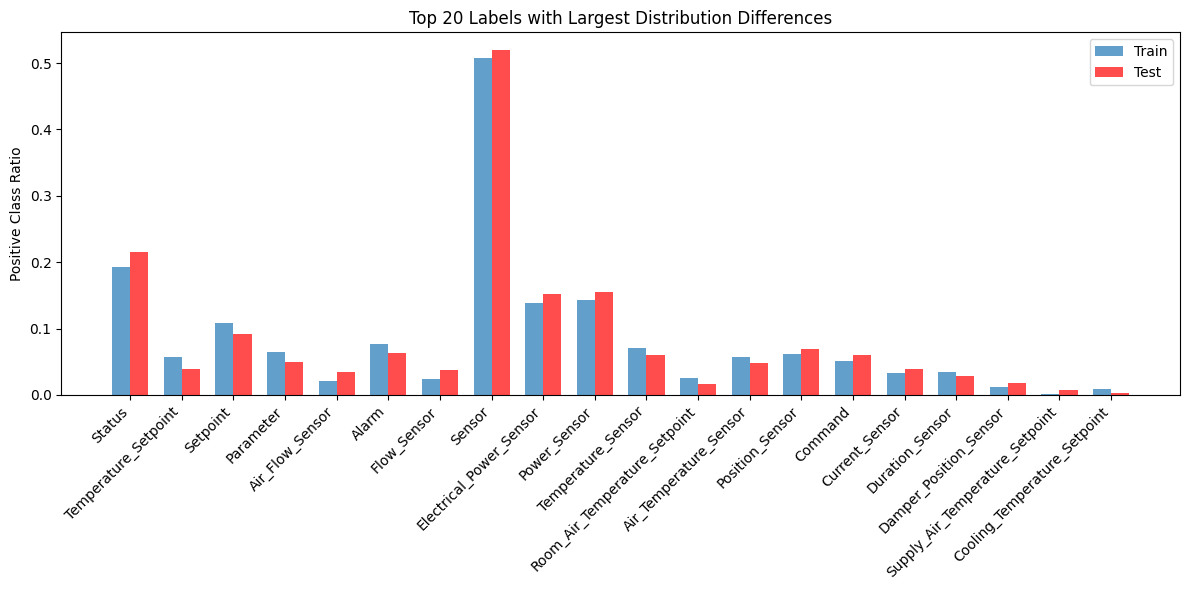

🧪 共有 58 个标签在训练集与测试集间呈现显著分布差异 (p < 0.05)


In [ ]:
diff_df = compare_label_distributions(Y_train, y_test)
plot_top_differences(diff_df, top_n=20)
sig_labels = chi_square_test(Y_train, y_test)

In [ ]:
def show_specific_label_diff(Y_train, Y_test, label_list):
    results = {}
    for label in label_list:
        if label not in Y_train.columns or label not in Y_test.columns:
            print(f"⚠️ 标签 '{label}' 不存在于数据中，跳过")
            continue

        train_pos = (Y_train[label] == 1).sum()
        train_total = ((Y_train[label] == 1) | (Y_train[label] == -1)).sum()
        train_ratio = train_pos / train_total if train_total > 0 else np.nan

        test_pos = (Y_test[label] == 1).sum()
        test_total = ((Y_test[label] == 1) | (Y_test[label] == -1)).sum()
        test_ratio = test_pos / test_total if test_total > 0 else np.nan

        results[label] = {
            "Train_Pos_Ratio": round(train_ratio, 4),
            "Test_Pos_Ratio": round(test_ratio, 4),
            "Difference": round(abs(train_ratio - test_ratio), 4)
        }

    return pd.DataFrame(results).T

# 查询标签
label_list = ['Cooling_Demand_Sensor', 'Heating_Demand_Sensor']
diff_df = show_specific_label_diff(Y_train, y_test, label_list)
print(diff_df)



                       Train_Pos_Ratio  Test_Pos_Ratio  Difference
Cooling_Demand_Sensor              0.0          0.0010      0.0010
Heating_Demand_Sensor              0.0          0.0007      0.0007


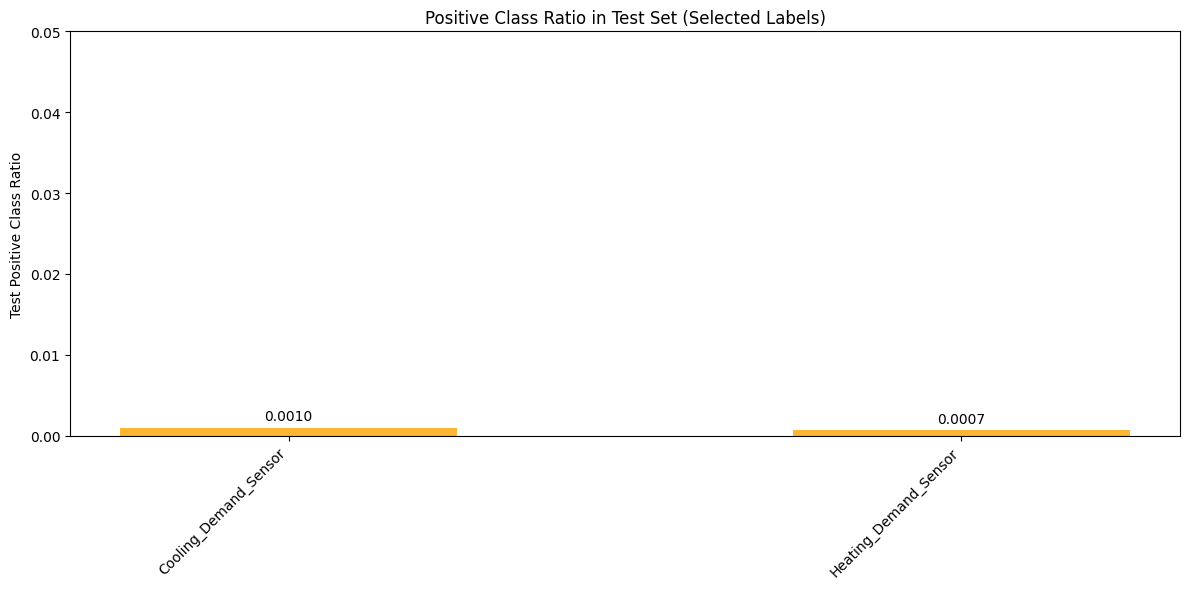

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_test_only_bar(diff_df, save_path=None):
    labels = diff_df.index.tolist()
    test_ratios = diff_df["Test_Pos_Ratio"].values

    x = np.arange(len(labels))
    width = 0.5

    fig, ax = plt.subplots(figsize=(12,6))
    bars = ax.bar(x, test_ratios, width, color='orange', alpha=0.8)

    ax.set_ylabel('Test Positive Class Ratio')
    ax.set_title('Positive Class Ratio in Test Set (Selected Labels)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(0, max(test_ratios.max() + 0.01, 0.05))  # 自动放大一点 y 轴，避免柱子太矮
    ax.bar_label(bars, fmt='%.4f', padding=3)

    plt.subplots_adjust(bottom=0.25)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"图像已保存到：{save_path}")

    plt.show()
plot_test_only_bar(diff_df)
